# Emergency Department Environment

In [158]:
import simpy
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import copy
import scienceplots
plt.style.use(['science'])

In [159]:
class Project:
    def __init__(self, name, time_distribution, staff_needed, **kwargs):
        self.name = name
        self.time_distribution = time_distribution
        self.staff_needed = staff_needed  # 该项目需要的工作人员数量
        if time_distribution == "uniform":
            self.min_time = kwargs.get('min_time', 0)
            self.max_time = kwargs.get('max_time', 0)
        elif time_distribution == "triangular":
            self.min_time = kwargs.get('min_time', 0)
            self.mode_time = kwargs.get('mode_time', 0)
            self.max_time = kwargs.get('max_time', 0)
    
    def get_time(self):
        if self.time_distribution == "uniform":
            return random.randint(self.min_time, self.max_time)
        elif self.time_distribution == "triangular":
            return int(np.random.triangular(self.min_time, self.mode_time, self.max_time))

In [160]:
class Staff:
    def __init__(self):
        self.staff_dict = {}  # 存储各种类型的工作人员和其数量
        self.staff_prices = {}  # 存储各种类型的工作人员和其价格

    def add_staff(self, staff_type, quantity, price):
        self.staff_dict[staff_type] = quantity
        self.staff_prices[staff_type] = price

    def assign_staff(self, staff_type, quantity):
        self.staff_dict[staff_type] -= quantity

    def release_staff(self, staff_type, quantity):
        self.staff_dict[staff_type] += quantity


In [161]:
class Patient:
    def __init__(self, env, name, projects, project_probabilities):
        self.env = env
        self.name = name
        self.all_projects = projects
        self.project_probabilities = project_probabilities
        
        self.current_project = None
        self.current_project_start_time = 0
        self.current_project_end_time = 0
        self.current_project_time = 0
        
        self.in_project = False
        self.is_waiting = False
        
        self.waiting_time = 0
        self.emergency_room_waiting_time = 0
        self.total_time = 0  # 记录总共花费的时间
        
        self.start_times = {}  # 记录每个项目的开始时间
        self.end_times = {}    # 记录每个项目的结束时间
        self.project_times = {}  # 记录每个项目使用的时间

        self.completed_projects = []  # 记录完成的项目

    def execute_project(self, project):
        self.in_project = True
        self.current_project_start_time = self.env.now
        self.start_times[self.current_project.name] = self.current_project_start_time  # 记录项目开始时间
        project_time = self.current_project.get_time()
        self.current_project_time = project_time
        # end_time = self.env.now
        # self.end_times[self.current_project.name] = end_time  # 记录项目结束时间
        self.project_times[self.current_project.name] = project_time  # 记录项目使用的时间
        self.total_time += project_time  # 更新总共花费的时间
        self.completed_projects.append(project)  # 记录完成的项目
        
    def check_finish(self):
        if self.env.now - self.current_project_start_time > self.current_project_time:
            self.in_project = False
            self.current_project_end_time = self.env.now
            if  self.current_project != None:
                self.end_times[self.current_project.name] = self.current_project_end_time

    def choose_next_project(self):
        current_project_name = self.current_project.name if self.current_project else None
        next_project_probabilities = self.project_probabilities.get(current_project_name, self.project_probabilities["default"])
        projects = list(next_project_probabilities.keys())
        probabilities = list(next_project_probabilities.values())
        # print(projects,probabilities)
        chosen_project = random.choices(projects, probabilities)[0]
        chosen_project = [project for project in self.all_projects if project.name == chosen_project][0]
        self.current_project = chosen_project
        return chosen_project


In [162]:
class EmergencyDepartment:
    def __init__(self, env, staff, projects, project_probabilities, arrival_time):
        self.env = env
        self.staff = staff
        self.projects = projects
        self.project_probabilities = project_probabilities
        self.patients = []
        self.discharged_patient = []
        self.arrival_time = arrival_time

    def admit_patient(self, patient):
        self.patients.append(patient)
        
    def process_patient(self, patients):
        while True:
            if self.env.now in self.arrival_time:
                self.admit_patient(Patient(self.env, len(self.patients)+1, self.projects, self.project_probabilities))
            for patient in patients:
                if patient in self.discharged_patient:
                    continue  # 跳过已经出院的患者
                
                if patient.current_project != None:
                    if patient.current_project.name == "Discharge":
                        self.discharged_patient.append(patient)
                        continue

                if not patient.in_project and not patient.is_waiting:  # 如果当前没有项目，则选择下一个项目
                    project = patient.choose_next_project()
                    if self.can_start_project(project):
                        self.assign_staff(project)
                        patient.execute_project(project)
                    else:
                        patient.waiting_time += 1
                        patient.is_waiting = True 
                        if patient.current_project.name == "Emergency room":
                            patient.emergency_room_waiting_time += 1
                    continue
                
                if not patient.in_project and patient.is_waiting:  # 如果当前没有项目，则选择下一个项目
                    project = patient.current_project
                    
                    if self.can_start_project(project):
                        self.assign_staff(project)
                        patient.execute_project(project)
                        patient.is_waiting = False
                    else:
                        patient.waiting_time += 1
                        if patient.current_project.name == "Emergency room":
                            patient.emergency_room_waiting_time += 1
                    continue
                
                patient.check_finish()
                if not patient.in_project:
                    project = patient.completed_projects[-1]
                    self.release_staff(project)
                    
            yield self.env.timeout(1)  # 继续等待1个单位时间
            
    def can_start_project(self, project):
        staff_needed = project.staff_needed
        project_name = project.name
        if project_name in self.staff.staff_dict:
            available_staff = self.staff.staff_dict[project_name]
            return staff_needed <= available_staff
        else:
            return False

    def assign_staff(self, project):
        staff_needed = project.staff_needed
        project_name = project.name
        if project_name in ["Examination room", "Reexamination process"]:
            self.staff.assign_staff("Examination room", staff_needed)
            self.staff.assign_staff("Reexamination process", staff_needed)
        # elif project_name =="Emergency room":
        #     if self.staff.staff_dict[project_name] < staff_needed:
        #         self.staff.assign_staff("Examination room", staff_needed)
        #         self.staff.assign_staff("Reexamination process", staff_needed) 
        #     else:
        #         self.staff.assign_staff(project_name, staff_needed)
        else:
            self.staff.assign_staff(project_name, staff_needed)

    def release_staff(self, project):
        staff_needed = project.staff_needed
        project_name = project.name
        if project_name in ["Examination room", "Reexamination process"]:
            self.staff.release_staff("Examination room", staff_needed)
            self.staff.release_staff("Reexamination process", staff_needed)
        # elif project_name == "Emergency room":
        #     if self.staff.staff_dict[project_name] < staff_needed:
        #         self.staff.release_staff("Examination room", staff_needed)
        #         self.staff.release_staff("Reexamination process", staff_needed) 
        #     else:
        #         self.staff.release_staff(project_name, staff_needed)
        else:
            self.staff.release_staff(project_name, staff_needed)


In [163]:
def calculate_average_waiting_time(waiting_times):
    if waiting_times:
        return sum(waiting_times) / len(waiting_times)
    else:
        return 0
    
def arrival_times(arrival_rates: list):
    hour = range(len(arrival_rates))
    arr_time = []
    for h in hour:
        for t in np.linspace(h*60,(h+1)*60,int(round(arrival_rates[h]))+1):
            arr_time.append(round(t))
        arr_time = arr_time[:-1]
    return arr_time

def calculate_discharge_per_hour(emergency_department):
    discharge_count_per_hour = {}
    for hour in range(24):  # 遍历24小时
        discharge_count_per_hour[hour] = 0  # 初始化每小时的出院人数为0
    for patient in emergency_department.patients:
        completed_projects = patient.completed_projects
        if completed_projects and completed_projects[-1].name == "Discharge":  # 检查是否有完成的项目，并且最后一个项目是"Discharge"
            discharge_time = patient.start_times.get("Discharge", -1)  # 获取"Discharge"项目的开始时间
            if discharge_time != -1:  # 如果有"Discharge"项目
                hour = discharge_time // 60  # 计算"Discharge"项目开始的小时
                discharge_count_per_hour[hour] += 1  # 对应小时的出院人数加1
    return discharge_count_per_hour



## Test

In [164]:
env = simpy.Environment()

# 定义病人每小时到达率
arrival_rates = [5.33, 5.33, 3.82, 3.82, 3.06, 3.06, 4.54, 4.54, 6.81, 6.84, 8.32, 8.32, 
                    9.01, 9.01, 8.36, 7.5, 8.32, 7.5, 8.32, 8.32, 7.5, 5.33, 3.82, 2.3]
# arrival_rates = [i*10 for i in arrival_rates]
arrival_time = arrival_times(arrival_rates)

# 创建不同项目
projects = [
    Project("default", "uniform", staff_needed=0, min_time=0, max_time=0),
    Project("Reception", "uniform", staff_needed=1, min_time=5, max_time=10),
    Project("Examination room", "uniform", staff_needed=1, min_time=10, max_time=20),
    Project("Lab tests", "triangular", staff_needed=1, min_time=10, mode_time=20, max_time=30),
    Project("Reexamination process", "uniform", staff_needed=1, min_time=7, max_time=12),
    Project("Treatment room", "uniform", staff_needed=1, min_time=20, max_time=30),
    Project("Emergency room", "uniform", staff_needed=3, min_time=60, max_time=120),
    Project("Discharge", "uniform", staff_needed=0, min_time=0, max_time=0)  # 出院项目
]

# 创建工作人员
staff = Staff()
staff.add_staff("default", 0, 0)
staff.add_staff("Reception", 1, 0.4)
staff.add_staff("Lab tests", 2, 0.5)
staff.add_staff("Examination room", 3, 1.2)
staff.add_staff("Reexamination process", 3, 1.2)
staff.add_staff("Treatment room", 2, 0.3)
staff.add_staff("Emergency room", 7, 0.3)
staff.add_staff("Discharge", 0, 0)

project_probabilities = {
    "default": {"Reception": 1.0, "Lab tests": 0.0, "Examination room": 0.0,
                "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
    "Reception": {"Examination room": 1.0, "Lab tests": 0.0, "Reexamination process": 0.0,
                "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
    "Examination room": {"Treatment room": 0.2, "Lab tests": 0.5, "Discharge": 0.05, "Emergency room": 0.25,
                        "Reception": 0.0, "Reexamination process": 0.0},
    "Lab tests": {"Reexamination process": 1.0, "Reception": 0.0, "Examination room": 0.0,
                "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
    "Reexamination process": {"Treatment room": 0.4, "Discharge": 0.1, "Emergency room": 0.5,
                            "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0},
    "Treatment room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                        "Reexamination process": 0.0, "Emergency room": 0.0},
    "Emergency room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                        "Reexamination process": 0.0, "Treatment room": 0.0},
    "Discharge": {"Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0}
}
emergency_department = EmergencyDepartment(env, staff, projects, project_probabilities, arrival_time)
env.process(emergency_department.process_patient(emergency_department.patients))
env.run(until=1440)  # 模拟24小时
for patient in emergency_department.patients:
    print(f"Patient: {patient.name}")
    print(f"Project: {[project.name for project in patient.completed_projects]}")
    for project in projects[1:]:
        start_time = patient.start_times.get(project.name, "Not Started")
        end_time = patient.end_times.get(project.name, "Not Finished")
        project_time = patient.project_times.get(project.name, 0)
        print(f"Project: {project.name}, Start Time: {start_time}, End Time: {end_time}, Project Time: {project_time}")
    print(f"Total Time Spent: {patient.total_time}")
    print(f"Total Waiting Time: {patient.waiting_time}")
    print(f"Emergency Room Waiting Time: {patient.emergency_room_waiting_time}")
    print("\n")
waiting_times_C1 = [patient.emergency_room_waiting_time for patient in emergency_department.patients if any(project.name == "Emergency room" for project in patient.completed_projects)]
average_waiting_time_C1 = calculate_average_waiting_time(waiting_times_C1)
print(f"C1病人的等待时间的平均值为: {average_waiting_time_C1:.2f} 分钟")

Patient: 1
Project: ['Reception', 'Examination room', 'Lab tests', 'Reexamination process', 'Treatment room', 'Discharge']
Project: Reception, Start Time: 0, End Time: 10, Project Time: 9
Project: Examination room, Start Time: 11, End Time: 29, Project Time: 17
Project: Lab tests, Start Time: 30, End Time: 51, Project Time: 20
Project: Reexamination process, Start Time: 52, End Time: 61, Project Time: 8
Project: Treatment room, Start Time: 62, End Time: 83, Project Time: 20
Project: Emergency room, Start Time: Not Started, End Time: Not Finished, Project Time: 0
Project: Discharge, Start Time: 84, End Time: Not Finished, Project Time: 0
Total Time Spent: 74
Total Waiting Time: 0
Emergency Room Waiting Time: 0


Patient: 2
Project: ['Reception', 'Examination room', 'Lab tests', 'Reexamination process', 'Treatment room', 'Discharge']
Project: Reception, Start Time: 12, End Time: 20, Project Time: 7
Project: Examination room, Start Time: 21, End Time: 33, Project Time: 11
Project: Lab tes

In [165]:
# 调用函数并打印每个小时的出院人数
discharge_per_hour = calculate_discharge_per_hour(emergency_department)
list(discharge_per_hour.values()), sum(list(discharge_per_hour.values()))

([0, 5, 5, 2, 2, 5, 2, 5, 5, 6, 4, 8, 5, 7, 3, 6, 6, 4, 0, 9, 2, 4, 5, 3], 103)

# To satisfy constraint (2) and constraint (4)
Constraint (2): $f_1(x_1,x_2,x_3,x_4,x_5) \leq B$  
Constraint (4): $1 \leq x_i \leq x_{i_{max}}, \forall i \in \{1,2,3,4,5\}$

In [166]:
def backtrack(x, cost, budget, x_max, x_cost, results): #回溯算法计算解的可行域
    if len(x) == len(x_max):
        if cost <= budget:
            results.append(x.copy())
        return

    for i in range(1, x_max[len(x)] + 1):
        new_cost = cost + i * x_cost[len(x)]
        if new_cost <= budget:
            x.append(i)
            backtrack(x, new_cost, budget, x_max, x_cost, results)
            x.pop()

def find_combinations(budget, x_max, x_cost):
    results = []
    backtrack([], 0, budget, x_max, x_cost, results)
    return results

budget = 7.7
x_max = [3, 4, 5, 6, 12]
x_cost = [0.4, 1.2, 0.5, 0.3, 0.3]

available_set = find_combinations(budget, x_max, x_cost)
print("All staff configurations:")
for configuration in available_set:
    print(configuration)
len(available_set)

All staff configurations:
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 2]
[1, 1, 1, 1, 3]
[1, 1, 1, 1, 4]
[1, 1, 1, 1, 5]
[1, 1, 1, 1, 6]
[1, 1, 1, 1, 7]
[1, 1, 1, 1, 8]
[1, 1, 1, 1, 9]
[1, 1, 1, 1, 10]
[1, 1, 1, 1, 11]
[1, 1, 1, 1, 12]
[1, 1, 1, 2, 1]
[1, 1, 1, 2, 2]
[1, 1, 1, 2, 3]
[1, 1, 1, 2, 4]
[1, 1, 1, 2, 5]
[1, 1, 1, 2, 6]
[1, 1, 1, 2, 7]
[1, 1, 1, 2, 8]
[1, 1, 1, 2, 9]
[1, 1, 1, 2, 10]
[1, 1, 1, 2, 11]
[1, 1, 1, 2, 12]
[1, 1, 1, 3, 1]
[1, 1, 1, 3, 2]
[1, 1, 1, 3, 3]
[1, 1, 1, 3, 4]
[1, 1, 1, 3, 5]
[1, 1, 1, 3, 6]
[1, 1, 1, 3, 7]
[1, 1, 1, 3, 8]
[1, 1, 1, 3, 9]
[1, 1, 1, 3, 10]
[1, 1, 1, 3, 11]
[1, 1, 1, 3, 12]
[1, 1, 1, 4, 1]
[1, 1, 1, 4, 2]
[1, 1, 1, 4, 3]
[1, 1, 1, 4, 4]
[1, 1, 1, 4, 5]
[1, 1, 1, 4, 6]
[1, 1, 1, 4, 7]
[1, 1, 1, 4, 8]
[1, 1, 1, 4, 9]
[1, 1, 1, 4, 10]
[1, 1, 1, 4, 11]
[1, 1, 1, 4, 12]
[1, 1, 1, 5, 1]
[1, 1, 1, 5, 2]
[1, 1, 1, 5, 3]
[1, 1, 1, 5, 4]
[1, 1, 1, 5, 5]
[1, 1, 1, 5, 6]
[1, 1, 1, 5, 7]
[1, 1, 1, 5, 8]
[1, 1, 1, 5, 9]
[1, 1, 1, 5, 10]
[1, 1, 1, 5, 11]
[1, 1, 1, 5, 12]

1704

# To satisfy constraint (3)
Constraint (3): $f_2(x_1,x_2,x_3,x_4,x_5) \leq Q_1$

In [167]:
# 计算时间太长

# def threshold(c, r, v, w, z):
#     return max(0, (w*z)/2*c*v - (v*r)/(2*c))

# def sample_variance(data:list):
#     n = len(data)
#     if n <= 1:
#         raise ValueError("样本容量必须大于1")
#     mean = sum(data) / n
#     return sum((x - mean) ** 2 for x in data) / (n - 1)

# def feasiblility_check(data:list, threshold, q):
#     data = [d-q for d in data]
#     if sum(data) <=  -threshold:
#         return 1
#     elif sum(data) >=  threshold:
#         return 2
#     else:
#         return 0
    
# def get_average_waiting_time(sample_time, staff_configurattion:list):
#     average_waiting_time = []
#     arrival_rates = [5.33, 5.33, 3.82, 3.82, 3.06, 3.06, 4.54, 4.54, 6.81, 6.84, 8.32, 8.32, 
#                             9.01, 9.01, 8.36, 7.5, 8.32, 7.5, 8.32, 8.32, 7.5, 5.33, 3.82, 2.3]
#     arrival_time = arrival_times(arrival_rates)
#     for _ in range(sample_time):
#         env = simpy.Environment()
#         projects = [
#             Project("default", "uniform", staff_needed=0, min_time=0, max_time=0),
#             Project("Reception", "uniform", staff_needed=1, min_time=5, max_time=10),
#             Project("Examination room", "uniform", staff_needed=1, min_time=10, max_time=20),
#             Project("Lab tests", "triangular", staff_needed=1, min_time=10, mode_time=20, max_time=30),
#             Project("Reexamination process", "uniform", staff_needed=1, min_time=7, max_time=12),
#             Project("Treatment room", "uniform", staff_needed=1, min_time=20, max_time=30),
#             Project("Emergency room", "uniform", staff_needed=3, min_time=60, max_time=120),
#             Project("Discharge", "uniform", staff_needed=0, min_time=0, max_time=0)  # 出院项目
#         ]
        
#         staff = Staff()
#         staff.add_staff("default", 0, 0)
#         staff.add_staff("Reception", staff_configurattion[0], 0.4)
#         staff.add_staff("Lab tests", staff_configurattion[2], 0.5)
#         staff.add_staff("Examination room", staff_configurattion[1], 1.2)
#         staff.add_staff("Reexamination process", staff_configurattion[1], 1.2)
#         staff.add_staff("Treatment room", staff_configurattion[3], 0.3)
#         staff.add_staff("Emergency room", staff_configurattion[4], 0.3)
#         staff.add_staff("Discharge", 0, 0)
        
#         project_probabilities = {
#             "default": {"Reception": 1.0, "Lab tests": 0.0, "Examination room": 0.0,
#                         "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
#             "Reception": {"Examination room": 1.0, "Lab tests": 0.0, "Reexamination process": 0.0,
#                         "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
#             "Examination room": {"Treatment room": 0.2, "Lab tests": 0.5, "Discharge": 0.05, "Emergency room": 0.25,
#                                 "Reception": 0.0, "Reexamination process": 0.0},
#             "Lab tests": {"Reexamination process": 1.0, "Reception": 0.0, "Examination room": 0.0,
#                         "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
#             "Reexamination process": {"Treatment room": 0.4, "Discharge": 0.1, "Emergency room": 0.5,
#                                     "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0},
#             "Treatment room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
#                                 "Reexamination process": 0.0, "Emergency room": 0.0},
#             "Emergency room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
#                                 "Reexamination process": 0.0, "Treatment room": 0.0},
#             "Discharge": {"Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
#                         "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0}
#         }
        
#         emergency_department = EmergencyDepartment(env, staff, projects, project_probabilities, arrival_time)
#         env.process(emergency_department.process_patient(emergency_department.patients))
#         env.run(until=1440)
#         waiting_times_C1 = [patient.emergency_room_waiting_time for patient in emergency_department.patients if any(project.name == "Emergency room" for project in patient.completed_projects)]
#         average_waiting_time_C1 = calculate_average_waiting_time(waiting_times_C1)
#         average_waiting_time.append(average_waiting_time_C1)
#     return average_waiting_time

In [168]:
# L = []

# Q1L = 60
# Q1R = 80
# c = 1 # 常量
# r = 10 # 初始模拟的次数
# v = (Q1R - Q1L) / 2 # 偏差
# mu = 9.89
# w = 2 * mu * c * 9
# z = 0 # 样本方差
# q = (Q1L + Q1R) / 2

# for configuration in available_set[:10]:
#     average_waiting_time = get_average_waiting_time(100, configuration)
#     z = sample_variance(average_waiting_time)
#     while feasiblility_check(average_waiting_time, threshold(c, r, v, w, z), q) == 0:
#         average_waiting_time.append(random.choice(average_waiting_time))
#         r += 1
#         print(r)
#     if feasiblility_check(average_waiting_time, threshold(c, r, v, w, z), q) == 1:
#         L.append(configuration)

In [169]:
def get_average_waiting_time(arrival_rates_multiple_times, sample_time, staff_configurattion:list):
    average_waiting_time = []
    arrival_rates = arrival_rates_multiple_times*[5.33, 5.33, 3.82, 3.82, 3.06, 3.06, 4.54, 4.54, 6.81, 6.84, 8.32, 8.32, 
                            9.01, 9.01, 8.36, 7.5, 8.32, 7.5, 8.32, 8.32, 7.5, 5.33, 3.82, 2.3]
    arrival_time = arrival_times(arrival_rates)
    for _ in range(sample_time):
        env = simpy.Environment()
        projects = [
            Project("default", "uniform", staff_needed=0, min_time=0, max_time=0),
            Project("Reception", "uniform", staff_needed=1, min_time=5, max_time=10),
            Project("Examination room", "uniform", staff_needed=1, min_time=10, max_time=20),
            Project("Lab tests", "triangular", staff_needed=1, min_time=10, mode_time=20, max_time=30),
            Project("Reexamination process", "uniform", staff_needed=1, min_time=7, max_time=12),
            Project("Treatment room", "uniform", staff_needed=1, min_time=20, max_time=30),
            Project("Emergency room", "uniform", staff_needed=1, min_time=60, max_time=120),
            Project("Discharge", "uniform", staff_needed=0, min_time=0, max_time=0)  # 出院项目
        ]
        
        staff = Staff()
        staff.add_staff("default", 0, 0)
        staff.add_staff("Reception", staff_configurattion[0], 0.4)
        staff.add_staff("Lab tests", staff_configurattion[2], 0.5)
        staff.add_staff("Examination room", staff_configurattion[1], 1.2)
        staff.add_staff("Reexamination process", staff_configurattion[1], 1.2)
        staff.add_staff("Treatment room", staff_configurattion[3], 0.3)
        staff.add_staff("Emergency room", staff_configurattion[4], 0.3)
        staff.add_staff("Discharge", 0, 0)
        
        project_probabilities = {
            "default": {"Reception": 1.0, "Lab tests": 0.0, "Examination room": 0.0,
                        "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
            "Reception": {"Examination room": 1.0, "Lab tests": 0.0, "Reexamination process": 0.0,
                        "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
            "Examination room": {"Treatment room": 0.2, "Lab tests": 0.5, "Discharge": 0.05, "Emergency room": 0.25,
                                "Reception": 0.0, "Reexamination process": 0.0},
            "Lab tests": {"Reexamination process": 1.0, "Reception": 0.0, "Examination room": 0.0,
                        "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
            "Reexamination process": {"Treatment room": 0.4, "Discharge": 0.1, "Emergency room": 0.5,
                                    "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0},
            "Treatment room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                                "Reexamination process": 0.0, "Emergency room": 0.0},
            "Emergency room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                                "Reexamination process": 0.0, "Treatment room": 0.0},
            "Discharge": {"Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                        "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0}
        }
        
        emergency_department = EmergencyDepartment(env, staff, projects, project_probabilities, arrival_time)
        env.process(emergency_department.process_patient(emergency_department.patients))
        env.run(until=1440)
        waiting_times_C1 = [patient.emergency_room_waiting_time for patient in emergency_department.patients if any(project.name == "Emergency room" for project in patient.completed_projects)]
        average_waiting_time_C1 = calculate_average_waiting_time(waiting_times_C1)
        average_waiting_time.append(average_waiting_time_C1)
    return average_waiting_time

In [170]:
# 每个工作人员组合做10次模拟，记录每1次的平均等待时间，取其中10个平均值的最大值，不能超过180分钟
F = []

for configuration in available_set:
    average_waiting_time = get_average_waiting_time(1, 10, configuration)
    if max(average_waiting_time) <= 180: # Waiting time should be smaller than 180 minites
        F.append(configuration)
        
len(F)

1221

# Optimization algorithm

In [171]:
def get_discharge_number(arrival_rates_multiple_times, staff_configurattion:list):
    arrival_rates = arrival_rates_multiple_times * [5.33, 5.33, 3.82, 3.82, 3.06, 3.06, 4.54, 4.54, 6.81, 6.84, 8.32, 8.32, 
                            9.01, 9.01, 8.36, 7.5, 8.32, 7.5, 8.32, 8.32, 7.5, 5.33, 3.82, 2.3]
    arrival_time = arrival_times(arrival_rates)
    
    env = simpy.Environment()
    
    projects = [
            Project("default", "uniform", staff_needed=0, min_time=0, max_time=0),
            Project("Reception", "uniform", staff_needed=1, min_time=5, max_time=10),
            Project("Examination room", "uniform", staff_needed=1, min_time=10, max_time=20),
            Project("Lab tests", "triangular", staff_needed=1, min_time=10, mode_time=20, max_time=30),
            Project("Reexamination process", "uniform", staff_needed=1, min_time=7, max_time=12),
            Project("Treatment room", "uniform", staff_needed=1, min_time=20, max_time=30),
            Project("Emergency room", "uniform", staff_needed=1, min_time=60, max_time=120),
            Project("Discharge", "uniform", staff_needed=0, min_time=0, max_time=0)  # 出院项目
        ]
    
    staff = Staff()
    staff.add_staff("default", 0, 0)
    staff.add_staff("Reception", staff_configurattion[0], 0.4)
    staff.add_staff("Lab tests", staff_configurattion[2], 0.5)
    staff.add_staff("Examination room", staff_configurattion[1], 1.2)
    staff.add_staff("Reexamination process", staff_configurattion[1], 1.2)
    staff.add_staff("Treatment room", staff_configurattion[3], 0.3)
    staff.add_staff("Emergency room", staff_configurattion[4], 0.3)
    staff.add_staff("Discharge", 0, 0)
    
    project_probabilities = {
        "default": {"Reception": 1.0, "Lab tests": 0.0, "Examination room": 0.0,
                    "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
        "Reception": {"Examination room": 1.0, "Lab tests": 0.0, "Reexamination process": 0.0,
                    "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
        "Examination room": {"Treatment room": 0.2, "Lab tests": 0.5, "Discharge": 0.05, "Emergency room": 0.25,
                            "Reception": 0.0, "Reexamination process": 0.0},
        "Lab tests": {"Reexamination process": 1.0, "Reception": 0.0, "Examination room": 0.0,
                    "Treatment room": 0.0, "Emergency room": 0.0, "Discharge": 0.0},
        "Reexamination process": {"Treatment room": 0.4, "Discharge": 0.1, "Emergency room": 0.5,
                                "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0},
        "Treatment room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                            "Reexamination process": 0.0, "Emergency room": 0.0},
        "Emergency room": {"Discharge": 1.0, "Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                            "Reexamination process": 0.0, "Treatment room": 0.0},
        "Discharge": {"Reception": 0.0, "Lab tests": 0.0, "Examination room": 0.0,
                    "Reexamination process": 0.0, "Treatment room": 0.0, "Emergency room": 0.0}
    }
    
    emergency_department = EmergencyDepartment(env, staff, projects, project_probabilities, arrival_time)
    
    env.process(emergency_department.process_patient(emergency_department.patients))
    env.run(until=1440)
    
    discharge_count_per_hour = {}
    for hour in range(24):  # 遍历24小时
        discharge_count_per_hour[hour] = 0  # 初始化每小时的出院人数为0
    for patient in emergency_department.patients:
        completed_projects = patient.completed_projects
        if completed_projects and completed_projects[-1].name == "Discharge":  # 检查是否有完成的项目，并且最后一个项目是"Discharge"
            discharge_time = patient.start_times.get("Discharge", -1)  # 获取"Discharge"项目的开始时间
            if discharge_time != -1:  # 如果有"Discharge"项目
                hour = discharge_time // 60  # 计算"Discharge"项目开始的小时
                discharge_count_per_hour[hour] += 1  # 对应小时的出院人数加1
    return sum(list(discharge_count_per_hour.values()))

def find_optimal_configuration(bound, feasible_set, arrival_rates_multiple_times):
    FF = copy.deepcopy(feasible_set)
    i = random.choice(FF)
    FF.remove(i)
    
    T_total = []
    
    configuration_pair = []
    X = []
    T = []
    current_configuration = i

    for _ in tqdm(range(len(FF) - 1)):
        j = random.choice(FF)
        FF.remove(j)
        configuration_pair.append((current_configuration, j))
        while sum(X) > -bound and sum(X) < bound:
            discharge_number_current_configuration = get_discharge_number(arrival_rates_multiple_times, current_configuration)
            discharge_number_j = get_discharge_number(arrival_rates_multiple_times, j)
            if discharge_number_current_configuration < discharge_number_j:
                X.append(1)
            elif discharge_number_current_configuration > discharge_number_j:
                X.append(-1)
            else:
                X.append(0)
            T.append(sum(X))
        T_total.append(T)
        print(T)
        if sum(X) >= bound:
            current_configuration = j
        T = []
        X = []
        
    optimal_configuration = current_configuration 
    
    return optimal_configuration, configuration_pair, T_total

In [172]:
optimal_configuration, configuration_pair, T_total = find_optimal_configuration(3, F, 1)
optimal_configuration

  0%|          | 1/1219 [00:00<06:45,  3.01it/s]

[1, 2, 3]


  0%|          | 2/1219 [00:00<06:48,  2.98it/s]

[1, 2, 3]


  0%|          | 3/1219 [00:00<06:41,  3.03it/s]

[-1, -2, -3]


  0%|          | 4/1219 [00:01<06:38,  3.05it/s]

[-1, -2, -3]


  0%|          | 5/1219 [00:01<06:42,  3.02it/s]

[-1, -2, -3]


  0%|          | 6/1219 [00:01<06:42,  3.01it/s]

[-1, -2, -3]


  1%|          | 7/1219 [00:02<06:38,  3.04it/s]

[-1, -2, -3]


  1%|          | 8/1219 [00:02<06:37,  3.05it/s]

[-1, -2, -3]


  1%|          | 9/1219 [00:02<06:33,  3.07it/s]

[-1, -2, -3]


  1%|          | 10/1219 [00:03<06:33,  3.07it/s]

[-1, -2, -3]


  1%|          | 11/1219 [00:03<06:36,  3.05it/s]

[-1, -2, -3]


  1%|          | 12/1219 [00:03<06:35,  3.05it/s]

[-1, -2, -3]


  1%|          | 13/1219 [00:04<06:34,  3.06it/s]

[-1, -2, -3]


  1%|          | 14/1219 [00:04<06:33,  3.06it/s]

[-1, -2, -3]


  1%|          | 15/1219 [00:04<06:32,  3.07it/s]

[-1, -2, -3]


  1%|▏         | 16/1219 [00:05<06:35,  3.04it/s]

[-1, -2, -3]


  1%|▏         | 17/1219 [00:05<06:34,  3.05it/s]

[-1, -2, -3]


  1%|▏         | 18/1219 [00:05<06:32,  3.06it/s]

[-1, -2, -3]


  2%|▏         | 19/1219 [00:06<06:31,  3.06it/s]

[-1, -2, -3]


  2%|▏         | 20/1219 [00:06<06:34,  3.04it/s]

[-1, -2, -3]


  2%|▏         | 21/1219 [00:06<06:31,  3.06it/s]

[-1, -2, -3]


  2%|▏         | 22/1219 [00:07<06:30,  3.07it/s]

[-1, -2, -3]


  2%|▏         | 23/1219 [00:07<06:30,  3.07it/s]

[-1, -2, -3]


  2%|▏         | 24/1219 [00:07<06:30,  3.06it/s]

[-1, -2, -3]


  2%|▏         | 25/1219 [00:08<06:29,  3.06it/s]

[-1, -2, -3]


  2%|▏         | 26/1219 [00:08<06:28,  3.07it/s]

[-1, -2, -3]


  2%|▏         | 27/1219 [00:08<06:28,  3.06it/s]

[-1, -2, -3]


  2%|▏         | 28/1219 [00:09<06:28,  3.06it/s]

[-1, -2, -3]


  2%|▏         | 29/1219 [00:09<06:27,  3.07it/s]

[-1, -2, -3]


  2%|▏         | 30/1219 [00:09<06:27,  3.07it/s]

[-1, -2, -3]


  3%|▎         | 31/1219 [00:10<06:26,  3.07it/s]

[-1, -2, -3]


  3%|▎         | 32/1219 [00:10<06:26,  3.07it/s]

[-1, -2, -3]


  3%|▎         | 33/1219 [00:10<06:26,  3.07it/s]

[-1, -2, -3]


  3%|▎         | 34/1219 [00:11<06:24,  3.08it/s]

[-1, -2, -3]


  3%|▎         | 35/1219 [00:11<06:23,  3.09it/s]

[-1, -2, -3]


  3%|▎         | 36/1219 [00:11<06:27,  3.05it/s]

[-1, -2, -3]


  3%|▎         | 37/1219 [00:12<06:26,  3.06it/s]

[-1, -2, -3]


  3%|▎         | 38/1219 [00:12<06:24,  3.07it/s]

[-1, -2, -3]


  3%|▎         | 39/1219 [00:12<06:23,  3.08it/s]

[-1, -2, -3]


  3%|▎         | 40/1219 [00:13<06:26,  3.05it/s]

[-1, -2, -3]


  3%|▎         | 41/1219 [00:13<06:25,  3.06it/s]

[-1, -2, -3]


  3%|▎         | 42/1219 [00:13<06:24,  3.06it/s]

[-1, -2, -3]


  4%|▎         | 43/1219 [00:14<06:22,  3.07it/s]

[-1, -2, -3]


  4%|▎         | 44/1219 [00:14<06:27,  3.03it/s]

[-1, -2, -3]


  4%|▎         | 45/1219 [00:14<06:29,  3.02it/s]

[-1, -2, -3]


  4%|▍         | 46/1219 [00:15<06:26,  3.04it/s]

[-1, -2, -3]


  4%|▍         | 47/1219 [00:15<06:28,  3.02it/s]

[-1, -2, -3]


  4%|▍         | 48/1219 [00:15<06:25,  3.04it/s]

[-1, -2, -3]


  4%|▍         | 49/1219 [00:16<06:27,  3.02it/s]

[-1, -2, -3]


  4%|▍         | 50/1219 [00:16<06:25,  3.03it/s]

[-1, -2, -3]


  4%|▍         | 51/1219 [00:16<06:24,  3.04it/s]

[-1, -2, -3]


  4%|▍         | 52/1219 [00:17<06:26,  3.02it/s]

[-1, -2, -3]


  4%|▍         | 53/1219 [00:17<06:28,  3.00it/s]

[-1, -2, -3]


  4%|▍         | 54/1219 [00:17<06:28,  3.00it/s]

[-1, -2, -3]


  5%|▍         | 55/1219 [00:18<06:28,  2.99it/s]

[-1, -2, -3]


  5%|▍         | 56/1219 [00:18<06:25,  3.02it/s]

[-1, -2, -3]


  5%|▍         | 57/1219 [00:18<06:26,  3.00it/s]

[-1, -2, -3]


  5%|▍         | 58/1219 [00:19<06:24,  3.02it/s]

[-1, -2, -3]


  5%|▍         | 59/1219 [00:19<06:24,  3.02it/s]

[-1, -2, -3]


  5%|▍         | 60/1219 [00:19<06:28,  2.98it/s]

[-1, -2, -3]


  5%|▌         | 61/1219 [00:20<06:24,  3.01it/s]

[-1, -2, -3]


  5%|▌         | 62/1219 [00:20<06:20,  3.04it/s]

[-1, -2, -3]


  5%|▌         | 63/1219 [00:20<06:23,  3.02it/s]

[-1, -2, -3]


  5%|▌         | 64/1219 [00:21<06:20,  3.04it/s]

[-1, -2, -3]


  5%|▌         | 65/1219 [00:21<06:22,  3.02it/s]

[-1, -2, -3]


  5%|▌         | 66/1219 [00:21<06:23,  3.00it/s]

[-1, -2, -3]


  5%|▌         | 67/1219 [00:22<06:21,  3.02it/s]

[-1, -2, -3]


  6%|▌         | 68/1219 [00:22<06:19,  3.03it/s]

[-1, -2, -3]


  6%|▌         | 69/1219 [00:22<06:22,  3.00it/s]

[-1, -2, -3]


  6%|▌         | 70/1219 [00:23<06:19,  3.03it/s]

[-1, -2, -3]


  6%|▌         | 71/1219 [00:23<06:18,  3.03it/s]

[-1, -2, -3]


  6%|▌         | 72/1219 [00:23<06:20,  3.01it/s]

[-1, -2, -3]


  6%|▌         | 73/1219 [00:24<06:21,  3.01it/s]

[-1, -2, -3]


  6%|▌         | 74/1219 [00:24<06:22,  3.00it/s]

[-1, -2, -3]


  6%|▌         | 75/1219 [00:24<06:19,  3.01it/s]

[-1, -2, -3]


  6%|▌         | 76/1219 [00:25<06:20,  3.00it/s]

[-1, -2, -3]


  6%|▋         | 77/1219 [00:25<06:18,  3.02it/s]

[-1, -2, -3]


  6%|▋         | 78/1219 [00:25<06:20,  3.00it/s]

[-1, -2, -3]


  6%|▋         | 79/1219 [00:25<06:15,  3.04it/s]

[-1, -2, -3]


  7%|▋         | 80/1219 [00:26<06:14,  3.04it/s]

[-1, -2, -3]


  7%|▋         | 81/1219 [00:26<06:14,  3.04it/s]

[-1, -2, -3]


  7%|▋         | 82/1219 [00:26<06:12,  3.05it/s]

[-1, -2, -3]


  7%|▋         | 83/1219 [00:27<06:15,  3.03it/s]

[-1, -2, -3]


  7%|▋         | 84/1219 [00:27<06:13,  3.04it/s]

[-1, -2, -3]


  7%|▋         | 85/1219 [00:27<06:11,  3.05it/s]

[-1, -2, -3]


  7%|▋         | 86/1219 [00:28<06:13,  3.03it/s]

[-1, -2, -3]


  7%|▋         | 87/1219 [00:28<06:15,  3.01it/s]

[-1, -2, -3]


  7%|▋         | 88/1219 [00:28<06:12,  3.04it/s]

[-1, -2, -3]


  7%|▋         | 89/1219 [00:29<06:10,  3.05it/s]

[-1, -2, -3]


  7%|▋         | 90/1219 [00:29<06:10,  3.05it/s]

[-1, -2, -3]


  7%|▋         | 91/1219 [00:29<06:12,  3.03it/s]

[-1, -2, -3]


  8%|▊         | 92/1219 [00:30<06:12,  3.02it/s]

[-1, -2, -3]


  8%|▊         | 93/1219 [00:30<06:14,  3.01it/s]

[-1, -2, -3]


  8%|▊         | 94/1219 [00:30<06:14,  3.00it/s]

[-1, -2, -3]


  8%|▊         | 95/1219 [00:31<06:11,  3.03it/s]

[-1, -2, -3]


  8%|▊         | 96/1219 [00:31<06:09,  3.04it/s]

[-1, -2, -3]


  8%|▊         | 97/1219 [00:31<06:11,  3.02it/s]

[-1, -2, -3]


  8%|▊         | 98/1219 [00:32<06:08,  3.04it/s]

[-1, -2, -3]


  8%|▊         | 99/1219 [00:32<06:11,  3.01it/s]

[-1, -2, -3]


  8%|▊         | 100/1219 [00:32<06:12,  3.01it/s]

[-1, -2, -3]


  8%|▊         | 101/1219 [00:33<06:12,  3.00it/s]

[-1, -2, -3]


  8%|▊         | 102/1219 [00:33<06:13,  2.99it/s]

[-1, -2, -3]


  8%|▊         | 103/1219 [00:33<06:13,  2.99it/s]

[-1, -2, -3]


  9%|▊         | 104/1219 [00:34<06:13,  2.99it/s]

[-1, -2, -3]


  9%|▊         | 105/1219 [00:34<06:10,  3.01it/s]

[-1, -2, -3]


  9%|▊         | 106/1219 [00:34<06:07,  3.03it/s]

[-1, -2, -3]


  9%|▉         | 107/1219 [00:35<06:06,  3.03it/s]

[-1, -2, -3]


  9%|▉         | 108/1219 [00:35<06:05,  3.04it/s]

[-1, -2, -3]


  9%|▉         | 109/1219 [00:35<06:04,  3.04it/s]

[-1, -2, -3]


  9%|▉         | 110/1219 [00:36<06:07,  3.02it/s]

[-1, -2, -3]


  9%|▉         | 111/1219 [00:36<06:05,  3.03it/s]

[-1, -2, -3]


  9%|▉         | 112/1219 [00:36<06:04,  3.04it/s]

[-1, -2, -3]


  9%|▉         | 113/1219 [00:37<06:03,  3.04it/s]

[-1, -2, -3]


  9%|▉         | 114/1219 [00:37<06:02,  3.05it/s]

[-1, -2, -3]


  9%|▉         | 115/1219 [00:37<06:01,  3.06it/s]

[-1, -2, -3]


 10%|▉         | 116/1219 [00:38<06:00,  3.06it/s]

[-1, -2, -3]


 10%|▉         | 117/1219 [00:38<05:59,  3.06it/s]

[-1, -2, -3]


 10%|▉         | 118/1219 [00:38<06:02,  3.04it/s]

[-1, -2, -3]


 10%|▉         | 119/1219 [00:39<06:00,  3.05it/s]

[-1, -2, -3]


 10%|▉         | 120/1219 [00:39<05:58,  3.06it/s]

[-1, -2, -3]


 10%|▉         | 121/1219 [00:40<07:15,  2.52it/s]

[1, 0, -1, -2, -3]


 10%|█         | 122/1219 [00:40<06:51,  2.66it/s]

[-1, -2, -3]


 10%|█         | 123/1219 [00:40<06:38,  2.75it/s]

[-1, -2, -3]


 10%|█         | 124/1219 [00:41<06:25,  2.84it/s]

[-1, -2, -3]


 10%|█         | 125/1219 [00:41<06:15,  2.91it/s]

[-1, -2, -3]


 10%|█         | 126/1219 [00:41<06:12,  2.93it/s]

[-1, -2, -3]


 10%|█         | 127/1219 [00:42<06:09,  2.95it/s]

[-1, -2, -3]


 11%|█         | 128/1219 [00:42<06:03,  3.00it/s]

[-1, -2, -3]


 11%|█         | 129/1219 [00:42<06:01,  3.02it/s]

[-1, -2, -3]


 11%|█         | 130/1219 [00:43<07:18,  2.48it/s]

[-1, -2, -3]


 11%|█         | 131/1219 [00:43<06:52,  2.64it/s]

[-1, -2, -3]


 11%|█         | 132/1219 [00:43<06:38,  2.73it/s]

[-1, -2, -3]


 11%|█         | 133/1219 [00:44<06:29,  2.79it/s]

[-1, -2, -3]


 11%|█         | 134/1219 [00:44<06:22,  2.83it/s]

[-1, -2, -3]


 11%|█         | 135/1219 [00:44<06:17,  2.87it/s]

[-1, -2, -3]


 11%|█         | 136/1219 [00:45<06:13,  2.90it/s]

[-1, -2, -3]


 11%|█         | 137/1219 [00:45<06:08,  2.94it/s]

[-1, -2, -3]


 11%|█▏        | 138/1219 [00:45<06:06,  2.95it/s]

[-1, -2, -3]


 11%|█▏        | 139/1219 [00:46<06:01,  2.98it/s]

[-1, -2, -3]


 11%|█▏        | 140/1219 [00:46<05:58,  3.01it/s]

[-1, -2, -3]


 12%|█▏        | 141/1219 [00:46<05:55,  3.03it/s]

[-1, -2, -3]


 12%|█▏        | 142/1219 [00:47<05:53,  3.05it/s]

[-1, -2, -3]


 12%|█▏        | 143/1219 [00:47<05:52,  3.05it/s]

[-1, -2, -3]


 12%|█▏        | 144/1219 [00:47<05:54,  3.03it/s]

[-1, -2, -3]


 12%|█▏        | 145/1219 [00:48<05:56,  3.01it/s]

[-1, -2, -3]


 12%|█▏        | 146/1219 [00:48<05:57,  3.00it/s]

[-1, -2, -3]


 12%|█▏        | 147/1219 [00:48<05:54,  3.02it/s]

[-1, -2, -3]


 12%|█▏        | 148/1219 [00:49<05:53,  3.03it/s]

[-1, -2, -3]


 12%|█▏        | 149/1219 [00:49<05:51,  3.04it/s]

[-1, -2, -3]


 12%|█▏        | 150/1219 [00:49<05:49,  3.06it/s]

[-1, -2, -3]


 12%|█▏        | 151/1219 [00:50<05:48,  3.06it/s]

[-1, -2, -3]


 12%|█▏        | 152/1219 [00:50<05:51,  3.04it/s]

[-1, -2, -3]


 13%|█▎        | 153/1219 [00:50<05:53,  3.02it/s]

[-1, -2, -3]


 13%|█▎        | 154/1219 [00:51<05:50,  3.04it/s]

[-1, -2, -3]


 13%|█▎        | 155/1219 [00:51<05:49,  3.04it/s]

[-1, -2, -3]


 13%|█▎        | 156/1219 [00:51<05:47,  3.06it/s]

[-1, -2, -3]


 13%|█▎        | 157/1219 [00:52<05:52,  3.01it/s]

[-1, -2, -3]


 13%|█▎        | 158/1219 [00:52<05:54,  2.99it/s]

[-1, -2, -3]


 13%|█▎        | 159/1219 [00:52<05:55,  2.99it/s]

[-1, -2, -3]


 13%|█▎        | 160/1219 [00:53<05:55,  2.98it/s]

[-1, -2, -3]


 13%|█▎        | 161/1219 [00:53<05:51,  3.01it/s]

[-1, -2, -3]


 13%|█▎        | 162/1219 [00:53<05:49,  3.02it/s]

[-1, -2, -3]


 13%|█▎        | 163/1219 [00:54<05:48,  3.03it/s]

[-1, -2, -3]


 13%|█▎        | 164/1219 [00:54<05:46,  3.04it/s]

[-1, -2, -3]


 14%|█▎        | 165/1219 [00:54<05:46,  3.04it/s]

[-1, -2, -3]


 14%|█▎        | 166/1219 [00:55<05:45,  3.05it/s]

[-1, -2, -3]


 14%|█▎        | 167/1219 [00:55<05:46,  3.04it/s]

[-1, -2, -3]


 14%|█▍        | 168/1219 [00:55<05:44,  3.05it/s]

[-1, -2, -3]


 14%|█▍        | 169/1219 [00:56<05:43,  3.06it/s]

[-1, -2, -3]


 14%|█▍        | 170/1219 [00:56<05:45,  3.04it/s]

[-1, -2, -3]


 14%|█▍        | 171/1219 [00:56<05:44,  3.05it/s]

[-1, -2, -3]


 14%|█▍        | 172/1219 [00:57<05:42,  3.05it/s]

[-1, -2, -3]


 14%|█▍        | 173/1219 [00:57<05:42,  3.06it/s]

[-1, -2, -3]


 14%|█▍        | 174/1219 [00:57<05:45,  3.02it/s]

[-1, -2, -3]


 14%|█▍        | 175/1219 [00:58<05:43,  3.04it/s]

[-1, -2, -3]


 14%|█▍        | 176/1219 [00:58<05:41,  3.05it/s]

[-1, -2, -3]


 15%|█▍        | 177/1219 [00:58<05:40,  3.06it/s]

[-1, -2, -3]


 15%|█▍        | 178/1219 [00:59<05:43,  3.03it/s]

[-1, -2, -3]


 15%|█▍        | 179/1219 [00:59<05:45,  3.01it/s]

[-1, -2, -3]


 15%|█▍        | 180/1219 [00:59<05:42,  3.03it/s]

[-1, -2, -3]


 15%|█▍        | 181/1219 [01:00<05:44,  3.02it/s]

[-1, -2, -3]


 15%|█▍        | 182/1219 [01:00<05:40,  3.04it/s]

[-1, -2, -3]


 15%|█▌        | 183/1219 [01:00<05:42,  3.02it/s]

[-1, -2, -3]


 15%|█▌        | 184/1219 [01:01<05:40,  3.04it/s]

[-1, -2, -3]


 15%|█▌        | 185/1219 [01:01<05:38,  3.05it/s]

[-1, -2, -3]


 15%|█▌        | 186/1219 [01:01<05:37,  3.06it/s]

[-1, -2, -3]


 15%|█▌        | 187/1219 [01:02<05:41,  3.03it/s]

[-1, -2, -3]


 15%|█▌        | 188/1219 [01:02<05:39,  3.03it/s]

[-1, -2, -3]


 16%|█▌        | 189/1219 [01:02<05:42,  3.01it/s]

[-1, -2, -3]


 16%|█▌        | 190/1219 [01:03<05:39,  3.03it/s]

[-1, -2, -3]


 16%|█▌        | 191/1219 [01:03<05:41,  3.01it/s]

[-1, -2, -3]


 16%|█▌        | 192/1219 [01:03<05:42,  3.00it/s]

[-1, -2, -3]


 16%|█▌        | 193/1219 [01:04<05:41,  3.00it/s]

[-1, -2, -3]


 16%|█▌        | 194/1219 [01:04<05:39,  3.02it/s]

[-1, -2, -3]


 16%|█▌        | 195/1219 [01:04<05:38,  3.02it/s]

[-1, -2, -3]


 16%|█▌        | 196/1219 [01:05<05:36,  3.04it/s]

[-1, -2, -3]


 16%|█▌        | 197/1219 [01:05<05:40,  3.00it/s]

[-1, -2, -3]


 16%|█▌        | 198/1219 [01:05<05:38,  3.01it/s]

[-1, -2, -3]


 16%|█▋        | 199/1219 [01:06<05:39,  3.00it/s]

[-1, -2, -3]


 16%|█▋        | 200/1219 [01:06<05:39,  3.00it/s]

[-1, -2, -3]


 16%|█▋        | 201/1219 [01:06<05:36,  3.03it/s]

[-1, -2, -3]


 17%|█▋        | 202/1219 [01:07<05:33,  3.05it/s]

[-1, -2, -3]


 17%|█▋        | 203/1219 [01:07<05:32,  3.06it/s]

[-1, -2, -3]


 17%|█▋        | 204/1219 [01:07<05:35,  3.03it/s]

[-1, -2, -3]


 17%|█▋        | 205/1219 [01:08<05:34,  3.03it/s]

[-1, -2, -3]


 17%|█▋        | 206/1219 [01:08<05:32,  3.04it/s]

[-1, -2, -3]


 17%|█▋        | 207/1219 [01:08<05:34,  3.03it/s]

[-1, -2, -3]


 17%|█▋        | 208/1219 [01:09<05:36,  3.00it/s]

[-1, -2, -3]


 17%|█▋        | 209/1219 [01:09<05:37,  2.99it/s]

[-1, -2, -3]


 17%|█▋        | 210/1219 [01:09<05:34,  3.02it/s]

[-1, -2, -3]


 17%|█▋        | 211/1219 [01:10<05:35,  3.00it/s]

[-1, -2, -3]


 17%|█▋        | 212/1219 [01:10<05:32,  3.02it/s]

[-1, -2, -3]


 17%|█▋        | 213/1219 [01:10<05:30,  3.04it/s]

[-1, -2, -3]


 18%|█▊        | 214/1219 [01:11<05:30,  3.05it/s]

[-1, -2, -3]


 18%|█▊        | 215/1219 [01:11<05:30,  3.04it/s]

[-1, -2, -3]


 18%|█▊        | 216/1219 [01:11<05:28,  3.06it/s]

[-1, -2, -3]


 18%|█▊        | 217/1219 [01:12<05:29,  3.04it/s]

[-1, -2, -3]


 18%|█▊        | 218/1219 [01:12<05:29,  3.04it/s]

[-1, -2, -3]


 18%|█▊        | 219/1219 [01:12<05:27,  3.05it/s]

[-1, -2, -3]


 18%|█▊        | 220/1219 [01:12<05:26,  3.06it/s]

[-1, -2, -3]


 18%|█▊        | 221/1219 [01:13<05:29,  3.03it/s]

[-1, -2, -3]


 18%|█▊        | 222/1219 [01:13<05:27,  3.04it/s]

[-1, -2, -3]


 18%|█▊        | 223/1219 [01:13<05:30,  3.02it/s]

[-1, -2, -3]


 18%|█▊        | 224/1219 [01:14<05:28,  3.03it/s]

[-1, -2, -3]


 18%|█▊        | 225/1219 [01:14<05:29,  3.01it/s]

[-1, -2, -3]


 19%|█▊        | 226/1219 [01:14<05:27,  3.03it/s]

[-1, -2, -3]


 19%|█▊        | 227/1219 [01:15<05:24,  3.05it/s]

[-1, -2, -3]


 19%|█▊        | 228/1219 [01:15<05:24,  3.06it/s]

[-1, -2, -3]


 19%|█▉        | 229/1219 [01:15<05:26,  3.03it/s]

[-1, -2, -3]


 19%|█▉        | 230/1219 [01:16<05:29,  3.00it/s]

[-1, -2, -3]


 19%|█▉        | 231/1219 [01:16<05:30,  2.99it/s]

[-1, -2, -3]


 19%|█▉        | 232/1219 [01:16<05:30,  2.99it/s]

[-1, -2, -3]


 19%|█▉        | 233/1219 [01:17<05:30,  2.98it/s]

[-1, -2, -3]


 19%|█▉        | 234/1219 [01:17<05:27,  3.01it/s]

[-1, -2, -3]


 19%|█▉        | 235/1219 [01:17<05:27,  3.00it/s]

[-1, -2, -3]


 19%|█▉        | 236/1219 [01:18<05:28,  2.99it/s]

[-1, -2, -3]


 19%|█▉        | 237/1219 [01:18<05:25,  3.02it/s]

[-1, -2, -3]


 20%|█▉        | 238/1219 [01:18<05:23,  3.03it/s]

[-1, -2, -3]


 20%|█▉        | 239/1219 [01:19<05:22,  3.04it/s]

[-1, -2, -3]


 20%|█▉        | 240/1219 [01:19<05:20,  3.06it/s]

[-1, -2, -3]


 20%|█▉        | 241/1219 [01:19<05:19,  3.06it/s]

[-1, -2, -3]


 20%|█▉        | 242/1219 [01:20<05:20,  3.05it/s]

[-1, -2, -3]


 20%|█▉        | 243/1219 [01:20<05:20,  3.05it/s]

[-1, -2, -3]


 20%|██        | 244/1219 [01:20<05:26,  2.99it/s]

[-1, -2, -3]


 20%|██        | 245/1219 [01:21<05:23,  3.01it/s]

[-1, -2, -3]


 20%|██        | 246/1219 [01:21<05:24,  3.00it/s]

[-1, -2, -3]


 20%|██        | 247/1219 [01:21<05:21,  3.02it/s]

[-1, -2, -3]


 20%|██        | 248/1219 [01:22<05:19,  3.04it/s]

[-1, -2, -3]


 20%|██        | 249/1219 [01:22<05:17,  3.05it/s]

[-1, -2, -3]


 21%|██        | 250/1219 [01:22<05:16,  3.06it/s]

[-1, -2, -3]


 21%|██        | 251/1219 [01:23<05:18,  3.04it/s]

[-1, -2, -3]


 21%|██        | 252/1219 [01:23<05:19,  3.02it/s]

[-1, -2, -3]


 21%|██        | 253/1219 [01:23<05:17,  3.04it/s]

[-1, -2, -3]


 21%|██        | 254/1219 [01:24<05:20,  3.01it/s]

[-1, -2, -3]


 21%|██        | 255/1219 [01:24<05:18,  3.03it/s]

[-1, -2, -3]


 21%|██        | 256/1219 [01:24<05:16,  3.04it/s]

[-1, -2, -3]


 21%|██        | 257/1219 [01:25<05:15,  3.05it/s]

[-1, -2, -3]


 21%|██        | 258/1219 [01:25<05:14,  3.06it/s]

[-1, -2, -3]


 21%|██        | 259/1219 [01:25<05:13,  3.06it/s]

[-1, -2, -3]


 21%|██▏       | 260/1219 [01:26<05:13,  3.06it/s]

[-1, -2, -3]


 21%|██▏       | 261/1219 [01:26<05:13,  3.05it/s]

[-1, -2, -3]


 21%|██▏       | 262/1219 [01:26<05:13,  3.05it/s]

[-1, -2, -3]


 22%|██▏       | 263/1219 [01:27<05:15,  3.03it/s]

[-1, -2, -3]


 22%|██▏       | 264/1219 [01:27<05:16,  3.01it/s]

[-1, -2, -3]


 22%|██▏       | 265/1219 [01:27<05:17,  3.00it/s]

[-1, -2, -3]


 22%|██▏       | 266/1219 [01:28<05:18,  3.00it/s]

[-1, -2, -3]


 22%|██▏       | 267/1219 [01:28<05:15,  3.02it/s]

[-1, -2, -3]


 22%|██▏       | 268/1219 [01:28<05:13,  3.03it/s]

[-1, -2, -3]


 22%|██▏       | 269/1219 [01:29<05:15,  3.01it/s]

[-1, -2, -3]


 22%|██▏       | 270/1219 [01:29<05:12,  3.03it/s]

[-1, -2, -3]


 22%|██▏       | 271/1219 [01:29<05:14,  3.02it/s]

[-1, -2, -3]


 22%|██▏       | 272/1219 [01:30<05:14,  3.01it/s]

[-1, -2, -3]


 22%|██▏       | 273/1219 [01:30<05:13,  3.02it/s]

[-1, -2, -3]


 22%|██▏       | 274/1219 [01:30<05:11,  3.04it/s]

[-1, -2, -3]


 23%|██▎       | 275/1219 [01:31<05:11,  3.03it/s]

[-1, -2, -3]


 23%|██▎       | 276/1219 [01:31<05:09,  3.04it/s]

[-1, -2, -3]


 23%|██▎       | 277/1219 [01:31<05:08,  3.05it/s]

[-1, -2, -3]


 23%|██▎       | 278/1219 [01:32<05:07,  3.06it/s]

[-1, -2, -3]


 23%|██▎       | 279/1219 [01:32<05:06,  3.06it/s]

[-1, -2, -3]


 23%|██▎       | 280/1219 [01:32<05:05,  3.07it/s]

[-1, -2, -3]


 23%|██▎       | 281/1219 [01:33<06:10,  2.53it/s]

[-1, 0, -1, -2, -3]


 23%|██▎       | 282/1219 [01:33<05:54,  2.64it/s]

[-1, -2, -3]


 23%|██▎       | 283/1219 [01:34<05:39,  2.76it/s]

[-1, -2, -3]


 23%|██▎       | 284/1219 [01:34<05:28,  2.84it/s]

[-1, -2, -3]


 23%|██▎       | 285/1219 [01:34<05:21,  2.90it/s]

[-1, -2, -3]


 23%|██▎       | 286/1219 [01:35<05:21,  2.90it/s]

[-1, -2, -3]


 24%|██▎       | 287/1219 [01:35<05:15,  2.95it/s]

[-1, -2, -3]


 24%|██▎       | 288/1219 [01:35<05:14,  2.96it/s]

[-1, -2, -3]


 24%|██▎       | 289/1219 [01:35<05:10,  3.00it/s]

[-1, -2, -3]


 24%|██▍       | 290/1219 [01:36<05:07,  3.02it/s]

[-1, -2, -3]


 24%|██▍       | 291/1219 [01:36<05:06,  3.03it/s]

[-1, -2, -3]


 24%|██▍       | 292/1219 [01:36<05:05,  3.03it/s]

[-1, -2, -3]


 24%|██▍       | 293/1219 [01:37<05:07,  3.01it/s]

[-1, -2, -3]


 24%|██▍       | 294/1219 [01:37<05:05,  3.02it/s]

[-1, -2, -3]


 24%|██▍       | 295/1219 [01:37<05:03,  3.05it/s]

[-1, -2, -3]


 24%|██▍       | 296/1219 [01:38<05:02,  3.06it/s]

[-1, -2, -3]


 24%|██▍       | 297/1219 [01:38<05:01,  3.05it/s]

[-1, -2, -3]


 24%|██▍       | 298/1219 [01:38<05:00,  3.07it/s]

[-1, -2, -3]


 25%|██▍       | 299/1219 [01:39<04:59,  3.07it/s]

[-1, -2, -3]


 25%|██▍       | 300/1219 [01:39<05:00,  3.06it/s]

[-1, -2, -3]


 25%|██▍       | 301/1219 [01:39<04:59,  3.07it/s]

[-1, -2, -3]


 25%|██▍       | 302/1219 [01:40<04:58,  3.07it/s]

[-1, -2, -3]


 25%|██▍       | 303/1219 [01:40<04:58,  3.07it/s]

[-1, -2, -3]


 25%|██▍       | 304/1219 [01:40<04:58,  3.07it/s]

[-1, -2, -3]


 25%|██▌       | 305/1219 [01:41<05:05,  2.99it/s]

[-1, -2, -3]


 25%|██▌       | 306/1219 [01:41<06:44,  2.26it/s]

[-1, -1, -2, -1, -2, -3]


 25%|██▌       | 307/1219 [01:42<06:15,  2.43it/s]

[-1, -2, -3]


 25%|██▌       | 308/1219 [01:42<05:51,  2.59it/s]

[-1, -2, -3]


 25%|██▌       | 309/1219 [01:42<05:34,  2.72it/s]

[-1, -2, -3]


 25%|██▌       | 310/1219 [01:43<05:25,  2.80it/s]

[-1, -2, -3]


 26%|██▌       | 311/1219 [01:43<05:19,  2.84it/s]

[-1, -2, -3]


 26%|██▌       | 312/1219 [01:43<05:15,  2.88it/s]

[-1, -2, -3]


 26%|██▌       | 313/1219 [01:44<05:08,  2.94it/s]

[-1, -2, -3]


 26%|██▌       | 314/1219 [01:44<05:04,  2.98it/s]

[-1, -2, -3]


 26%|██▌       | 315/1219 [01:44<05:01,  3.00it/s]

[-1, -2, -3]


 26%|██▌       | 316/1219 [01:45<05:02,  2.99it/s]

[-1, -2, -3]


 26%|██▌       | 317/1219 [01:45<04:59,  3.01it/s]

[-1, -2, -3]


 26%|██▌       | 318/1219 [01:45<04:58,  3.02it/s]

[-1, -2, -3]


 26%|██▌       | 319/1219 [01:46<04:59,  3.01it/s]

[-1, -2, -3]


 26%|██▋       | 320/1219 [01:46<04:55,  3.04it/s]

[-1, -2, -3]


 26%|██▋       | 321/1219 [01:46<04:55,  3.04it/s]

[-1, -2, -3]


 26%|██▋       | 322/1219 [01:47<04:55,  3.04it/s]

[-1, -2, -3]


 26%|██▋       | 323/1219 [01:47<04:53,  3.05it/s]

[-1, -2, -3]


 27%|██▋       | 324/1219 [01:47<04:52,  3.06it/s]

[-1, -2, -3]


 27%|██▋       | 325/1219 [01:48<04:54,  3.04it/s]

[-1, -2, -3]


 27%|██▋       | 326/1219 [01:48<04:53,  3.05it/s]

[-1, -2, -3]


 27%|██▋       | 327/1219 [01:48<04:52,  3.05it/s]

[-1, -2, -3]


 27%|██▋       | 328/1219 [01:49<04:54,  3.03it/s]

[-1, -2, -3]


 27%|██▋       | 329/1219 [01:49<04:55,  3.01it/s]

[-1, -2, -3]


 27%|██▋       | 330/1219 [01:49<04:53,  3.03it/s]

[-1, -2, -3]


 27%|██▋       | 331/1219 [01:50<04:54,  3.01it/s]

[-1, -2, -3]


 27%|██▋       | 332/1219 [01:50<04:55,  3.00it/s]

[-1, -2, -3]


 27%|██▋       | 333/1219 [01:50<04:53,  3.02it/s]

[-1, -2, -3]


 27%|██▋       | 334/1219 [01:51<04:52,  3.03it/s]

[-1, -2, -3]


 27%|██▋       | 335/1219 [01:51<04:50,  3.04it/s]

[-1, -2, -3]


 28%|██▊       | 336/1219 [01:51<04:49,  3.05it/s]

[-1, -2, -3]


 28%|██▊       | 337/1219 [01:52<04:48,  3.05it/s]

[-1, -2, -3]


 28%|██▊       | 338/1219 [01:52<04:48,  3.05it/s]

[-1, -2, -3]


 28%|██▊       | 339/1219 [01:52<04:47,  3.06it/s]

[-1, -2, -3]


 28%|██▊       | 340/1219 [01:53<04:50,  3.03it/s]

[-1, -2, -3]


 28%|██▊       | 341/1219 [01:53<04:49,  3.04it/s]

[-1, -2, -3]


 28%|██▊       | 342/1219 [01:53<04:48,  3.04it/s]

[-1, -2, -3]


 28%|██▊       | 343/1219 [01:54<04:47,  3.05it/s]

[-1, -2, -3]


 28%|██▊       | 344/1219 [01:54<04:45,  3.06it/s]

[-1, -2, -3]


 28%|██▊       | 345/1219 [01:54<04:54,  2.97it/s]

[-1, -2, -3]


 28%|██▊       | 346/1219 [01:55<04:51,  2.99it/s]

[-1, -2, -3]


 28%|██▊       | 347/1219 [01:55<04:49,  3.01it/s]

[-1, -2, -3]


 29%|██▊       | 348/1219 [01:55<04:47,  3.03it/s]

[-1, -2, -3]


 29%|██▊       | 349/1219 [01:56<04:46,  3.04it/s]

[-1, -2, -3]


 29%|██▊       | 350/1219 [01:56<04:44,  3.05it/s]

[-1, -2, -3]


 29%|██▉       | 351/1219 [01:56<04:43,  3.06it/s]

[-1, -2, -3]


 29%|██▉       | 352/1219 [01:57<04:43,  3.06it/s]

[-1, -2, -3]


 29%|██▉       | 353/1219 [01:57<04:45,  3.03it/s]

[-1, -2, -3]


 29%|██▉       | 354/1219 [01:57<04:44,  3.04it/s]

[-1, -2, -3]


 29%|██▉       | 355/1219 [01:58<04:46,  3.02it/s]

[-1, -2, -3]


 29%|██▉       | 356/1219 [01:58<04:44,  3.03it/s]

[-1, -2, -3]


 29%|██▉       | 357/1219 [01:58<04:43,  3.04it/s]

[-1, -2, -3]


 29%|██▉       | 358/1219 [01:59<04:41,  3.06it/s]

[-1, -2, -3]


 29%|██▉       | 359/1219 [01:59<04:40,  3.06it/s]

[-1, -2, -3]


 30%|██▉       | 360/1219 [01:59<04:40,  3.07it/s]

[-1, -2, -3]


 30%|██▉       | 361/1219 [02:00<04:42,  3.04it/s]

[-1, -2, -3]


 30%|██▉       | 362/1219 [02:00<04:41,  3.05it/s]

[-1, -2, -3]


 30%|██▉       | 363/1219 [02:00<04:40,  3.05it/s]

[-1, -2, -3]


 30%|██▉       | 364/1219 [02:01<04:39,  3.06it/s]

[-1, -2, -3]


 30%|██▉       | 365/1219 [02:01<04:38,  3.06it/s]

[-1, -2, -3]


 30%|███       | 366/1219 [02:01<04:41,  3.03it/s]

[-1, -2, -3]


 30%|███       | 367/1219 [02:02<04:40,  3.04it/s]

[-1, -2, -3]


 30%|███       | 368/1219 [02:02<04:39,  3.04it/s]

[-1, -2, -3]


 30%|███       | 369/1219 [02:02<04:41,  3.02it/s]

[-1, -2, -3]


 30%|███       | 370/1219 [02:03<04:40,  3.03it/s]

[-1, -2, -3]


 30%|███       | 371/1219 [02:03<04:39,  3.04it/s]

[-1, -2, -3]


 31%|███       | 372/1219 [02:03<04:38,  3.05it/s]

[-1, -2, -3]


 31%|███       | 373/1219 [02:04<04:36,  3.06it/s]

[-1, -2, -3]


 31%|███       | 374/1219 [02:04<04:36,  3.05it/s]

[-1, -2, -3]


 31%|███       | 375/1219 [02:04<04:38,  3.03it/s]

[-1, -2, -3]


 31%|███       | 376/1219 [02:04<04:36,  3.05it/s]

[-1, -2, -3]


 31%|███       | 377/1219 [02:05<04:38,  3.02it/s]

[-1, -2, -3]


 31%|███       | 378/1219 [02:05<04:35,  3.05it/s]

[-1, -2, -3]


 31%|███       | 379/1219 [02:05<04:37,  3.03it/s]

[-1, -2, -3]


 31%|███       | 380/1219 [02:06<04:35,  3.04it/s]

[-1, -2, -3]


 31%|███▏      | 381/1219 [02:06<04:34,  3.05it/s]

[-1, -2, -3]


 31%|███▏      | 382/1219 [02:06<04:36,  3.03it/s]

[-1, -2, -3]


 31%|███▏      | 383/1219 [02:07<04:37,  3.02it/s]

[-1, -2, -3]


 32%|███▏      | 384/1219 [02:07<04:40,  2.98it/s]

[-1, -2, -3]


 32%|███▏      | 385/1219 [02:08<04:43,  2.94it/s]

[-1, -2, -3]


 32%|███▏      | 386/1219 [02:08<04:42,  2.95it/s]

[-1, -2, -3]


 32%|███▏      | 387/1219 [02:08<04:41,  2.96it/s]

[-1, -2, -3]


 32%|███▏      | 388/1219 [02:09<04:38,  2.98it/s]

[-1, -2, -3]


 32%|███▏      | 389/1219 [02:09<04:35,  3.01it/s]

[-1, -2, -3]


 32%|███▏      | 390/1219 [02:09<04:34,  3.02it/s]

[-1, -2, -3]


 32%|███▏      | 391/1219 [02:09<04:35,  3.01it/s]

[-1, -2, -3]


 32%|███▏      | 392/1219 [02:10<04:32,  3.03it/s]

[-1, -2, -3]


 32%|███▏      | 393/1219 [02:10<04:34,  3.01it/s]

[-1, -2, -3]


 32%|███▏      | 394/1219 [02:10<04:35,  3.00it/s]

[-1, -2, -3]


 32%|███▏      | 395/1219 [02:11<04:32,  3.02it/s]

[-1, -2, -3]


 32%|███▏      | 396/1219 [02:11<04:33,  3.01it/s]

[-1, -2, -3]


 33%|███▎      | 397/1219 [02:11<04:31,  3.02it/s]

[-1, -2, -3]


 33%|███▎      | 398/1219 [02:12<04:32,  3.01it/s]

[-1, -2, -3]


 33%|███▎      | 399/1219 [02:12<04:30,  3.03it/s]

[-1, -2, -3]


 33%|███▎      | 400/1219 [02:12<04:32,  3.01it/s]

[-1, -2, -3]


 33%|███▎      | 401/1219 [02:13<04:30,  3.03it/s]

[-1, -2, -3]


 33%|███▎      | 402/1219 [02:13<04:31,  3.01it/s]

[-1, -2, -3]


 33%|███▎      | 403/1219 [02:13<04:32,  2.99it/s]

[-1, -2, -3]


 33%|███▎      | 404/1219 [02:14<04:32,  2.99it/s]

[-1, -2, -3]


 33%|███▎      | 405/1219 [02:14<05:54,  2.30it/s]

[0, -1, 0, -1, -2, -3]


 33%|███▎      | 406/1219 [02:15<05:26,  2.49it/s]

[-1, -2, -3]


 33%|███▎      | 407/1219 [02:15<05:07,  2.64it/s]

[-1, -2, -3]


 33%|███▎      | 408/1219 [02:15<04:54,  2.76it/s]

[-1, -2, -3]


 34%|███▎      | 409/1219 [02:16<04:44,  2.85it/s]

[-1, -2, -3]


 34%|███▎      | 410/1219 [02:16<04:37,  2.91it/s]

[-1, -2, -3]


 34%|███▎      | 411/1219 [02:16<04:32,  2.96it/s]

[-1, -2, -3]


 34%|███▍      | 412/1219 [02:17<04:32,  2.97it/s]

[-1, -2, -3]


 34%|███▍      | 413/1219 [02:17<04:31,  2.96it/s]

[-1, -2, -3]


 34%|███▍      | 414/1219 [02:17<04:29,  2.99it/s]

[-1, -2, -3]


 34%|███▍      | 415/1219 [02:18<04:30,  2.97it/s]

[-1, -2, -3]


 34%|███▍      | 416/1219 [02:18<04:27,  3.00it/s]

[-1, -2, -3]


 34%|███▍      | 417/1219 [02:18<04:25,  3.02it/s]

[-1, -2, -3]


 34%|███▍      | 418/1219 [02:19<04:26,  3.01it/s]

[-1, -2, -3]


 34%|███▍      | 419/1219 [02:19<04:23,  3.04it/s]

[-1, -2, -3]


 34%|███▍      | 420/1219 [02:19<04:22,  3.05it/s]

[-1, -2, -3]


 35%|███▍      | 421/1219 [02:20<04:22,  3.04it/s]

[-1, -2, -3]


 35%|███▍      | 422/1219 [02:20<04:27,  2.98it/s]

[-1, -2, -3]


 35%|███▍      | 423/1219 [02:20<04:25,  3.00it/s]

[-1, -2, -3]


 35%|███▍      | 424/1219 [02:21<04:23,  3.01it/s]

[-1, -2, -3]


 35%|███▍      | 425/1219 [02:21<04:21,  3.04it/s]

[-1, -2, -3]


 35%|███▍      | 426/1219 [02:21<04:20,  3.04it/s]

[-1, -2, -3]


 35%|███▌      | 427/1219 [02:22<04:19,  3.05it/s]

[-1, -2, -3]


 35%|███▌      | 428/1219 [02:22<04:19,  3.05it/s]

[-1, -2, -3]


 35%|███▌      | 429/1219 [02:22<04:18,  3.05it/s]

[-1, -2, -3]


 35%|███▌      | 430/1219 [02:23<04:21,  3.02it/s]

[-1, -2, -3]


 35%|███▌      | 431/1219 [02:23<04:22,  3.00it/s]

[-1, -2, -3]


 35%|███▌      | 432/1219 [02:23<04:23,  2.99it/s]

[-1, -2, -3]


 36%|███▌      | 433/1219 [02:24<04:21,  3.01it/s]

[-1, -2, -3]


 36%|███▌      | 434/1219 [02:24<04:23,  2.98it/s]

[-1, -2, -3]


 36%|███▌      | 435/1219 [02:24<04:20,  3.01it/s]

[-1, -2, -3]


 36%|███▌      | 436/1219 [02:25<04:21,  2.99it/s]

[-1, -2, -3]


 36%|███▌      | 437/1219 [02:25<04:19,  3.01it/s]

[-1, -2, -3]


 36%|███▌      | 438/1219 [02:25<04:20,  3.00it/s]

[-1, -2, -3]


 36%|███▌      | 439/1219 [02:26<04:17,  3.03it/s]

[-1, -2, -3]


 36%|███▌      | 440/1219 [02:26<04:18,  3.01it/s]

[-1, -2, -3]


 36%|███▌      | 441/1219 [02:26<04:19,  3.00it/s]

[-1, -2, -3]


 36%|███▋      | 442/1219 [02:27<04:19,  2.99it/s]

[-1, -2, -3]


 36%|███▋      | 443/1219 [02:27<04:17,  3.02it/s]

[-1, -2, -3]


 36%|███▋      | 444/1219 [02:27<04:15,  3.03it/s]

[-1, -2, -3]


 37%|███▋      | 445/1219 [02:28<04:14,  3.04it/s]

[-1, -2, -3]


 37%|███▋      | 446/1219 [02:28<04:13,  3.04it/s]

[-1, -2, -3]


 37%|███▋      | 447/1219 [02:28<04:16,  3.02it/s]

[-1, -2, -3]


 37%|███▋      | 448/1219 [02:29<04:14,  3.03it/s]

[-1, -2, -3]


 37%|███▋      | 449/1219 [02:29<04:12,  3.04it/s]

[-1, -2, -3]


 37%|███▋      | 450/1219 [02:29<04:11,  3.06it/s]

[-1, -2, -3]


 37%|███▋      | 451/1219 [02:30<04:10,  3.06it/s]

[-1, -2, -3]


 37%|███▋      | 452/1219 [02:30<04:10,  3.07it/s]

[-1, -2, -3]


 37%|███▋      | 453/1219 [02:30<04:10,  3.06it/s]

[-1, -2, -3]


 37%|███▋      | 454/1219 [02:31<04:09,  3.07it/s]

[-1, -2, -3]


 37%|███▋      | 455/1219 [02:31<04:14,  3.00it/s]

[-1, -2, -3]


 37%|███▋      | 456/1219 [02:31<04:12,  3.03it/s]

[-1, -2, -3]


 37%|███▋      | 457/1219 [02:32<04:09,  3.05it/s]

[-1, -2, -3]


 38%|███▊      | 458/1219 [02:32<04:11,  3.03it/s]

[-1, -2, -3]


 38%|███▊      | 459/1219 [02:32<04:12,  3.01it/s]

[-1, -2, -3]


 38%|███▊      | 460/1219 [02:33<04:10,  3.03it/s]

[-1, -2, -3]


 38%|███▊      | 461/1219 [02:33<04:11,  3.01it/s]

[-1, -2, -3]


 38%|███▊      | 462/1219 [02:33<04:09,  3.03it/s]

[-1, -2, -3]


 38%|███▊      | 463/1219 [02:34<04:08,  3.04it/s]

[-1, -2, -3]


 38%|███▊      | 464/1219 [02:34<04:10,  3.01it/s]

[-1, -2, -3]


 38%|███▊      | 465/1219 [02:34<04:11,  3.00it/s]

[-1, -2, -3]


 38%|███▊      | 466/1219 [02:35<04:11,  2.99it/s]

[-1, -2, -3]


 38%|███▊      | 467/1219 [02:35<04:08,  3.02it/s]

[-1, -2, -3]


 38%|███▊      | 468/1219 [02:35<04:07,  3.03it/s]

[-1, -2, -3]


 38%|███▊      | 469/1219 [02:36<04:09,  3.01it/s]

[-1, -2, -3]


 39%|███▊      | 470/1219 [02:36<04:09,  3.00it/s]

[-1, -2, -3]


 39%|███▊      | 471/1219 [02:36<04:07,  3.02it/s]

[-1, -2, -3]


 39%|███▊      | 472/1219 [02:37<04:05,  3.04it/s]

[-1, -2, -3]


 39%|███▉      | 473/1219 [02:37<04:07,  3.01it/s]

[-1, -2, -3]


 39%|███▉      | 474/1219 [02:37<04:08,  3.00it/s]

[-1, -2, -3]


 39%|███▉      | 475/1219 [02:38<04:08,  2.99it/s]

[-1, -2, -3]


 39%|███▉      | 476/1219 [02:38<04:06,  3.02it/s]

[-1, -2, -3]


 39%|███▉      | 477/1219 [02:38<04:07,  2.99it/s]

[-1, -2, -3]


 39%|███▉      | 478/1219 [02:39<04:05,  3.02it/s]

[-1, -2, -3]


 39%|███▉      | 479/1219 [02:39<04:03,  3.04it/s]

[-1, -2, -3]


 39%|███▉      | 480/1219 [02:39<04:04,  3.02it/s]

[-1, -2, -3]


 39%|███▉      | 481/1219 [02:40<04:05,  3.00it/s]

[-1, -2, -3]


 40%|███▉      | 482/1219 [02:40<04:04,  3.02it/s]

[-1, -2, -3]


 40%|███▉      | 483/1219 [02:40<04:03,  3.03it/s]

[-1, -2, -3]


 40%|███▉      | 484/1219 [02:41<04:04,  3.00it/s]

[-1, -2, -3]


 40%|███▉      | 485/1219 [02:41<04:03,  3.02it/s]

[-1, -2, -3]


 40%|███▉      | 486/1219 [02:41<04:05,  2.99it/s]

[-1, -2, -3]


 40%|███▉      | 487/1219 [02:42<04:03,  3.01it/s]

[-1, -2, -3]


 40%|████      | 488/1219 [02:42<04:01,  3.03it/s]

[-1, -2, -3]


 40%|████      | 489/1219 [02:42<04:02,  3.01it/s]

[-1, -2, -3]


 40%|████      | 490/1219 [02:43<04:00,  3.03it/s]

[-1, -2, -3]


 40%|████      | 491/1219 [02:43<03:59,  3.04it/s]

[-1, -2, -3]


 40%|████      | 492/1219 [02:43<04:00,  3.02it/s]

[-1, -2, -3]


 40%|████      | 493/1219 [02:44<04:02,  3.00it/s]

[-1, -2, -3]


 41%|████      | 494/1219 [02:44<04:01,  3.00it/s]

[-1, -2, -3]


 41%|████      | 495/1219 [02:44<04:00,  3.01it/s]

[-1, -2, -3]


 41%|████      | 496/1219 [02:45<03:58,  3.03it/s]

[-1, -2, -3]


 41%|████      | 497/1219 [02:45<03:57,  3.04it/s]

[-1, -2, -3]


 41%|████      | 498/1219 [02:45<03:55,  3.06it/s]

[-1, -2, -3]


 41%|████      | 499/1219 [02:46<03:57,  3.03it/s]

[-1, -2, -3]


 41%|████      | 500/1219 [02:46<03:59,  3.00it/s]

[-1, -2, -3]


 41%|████      | 501/1219 [02:46<03:59,  2.99it/s]

[-1, -2, -3]


 41%|████      | 502/1219 [02:47<03:57,  3.02it/s]

[-1, -2, -3]


 41%|████▏     | 503/1219 [02:47<03:55,  3.04it/s]

[-1, -2, -3]


 41%|████▏     | 504/1219 [02:47<03:54,  3.05it/s]

[-1, -2, -3]


 41%|████▏     | 505/1219 [02:48<03:53,  3.06it/s]

[-1, -2, -3]


 42%|████▏     | 506/1219 [02:48<03:52,  3.07it/s]

[-1, -2, -3]


 42%|████▏     | 507/1219 [02:48<03:54,  3.04it/s]

[-1, -2, -3]


 42%|████▏     | 508/1219 [02:49<03:52,  3.05it/s]

[-1, -2, -3]


 42%|████▏     | 509/1219 [02:49<03:54,  3.03it/s]

[-1, -2, -3]


 42%|████▏     | 510/1219 [02:49<03:52,  3.04it/s]

[-1, -2, -3]


 42%|████▏     | 511/1219 [02:50<03:54,  3.02it/s]

[-1, -2, -3]


 42%|████▏     | 512/1219 [02:50<03:53,  3.03it/s]

[-1, -2, -3]


 42%|████▏     | 513/1219 [02:50<03:53,  3.02it/s]

[-1, -2, -3]


 42%|████▏     | 514/1219 [02:51<03:54,  3.00it/s]

[-1, -2, -3]


 42%|████▏     | 515/1219 [02:51<03:52,  3.02it/s]

[-1, -2, -3]


 42%|████▏     | 516/1219 [02:51<03:52,  3.03it/s]

[-1, -2, -3]


 42%|████▏     | 517/1219 [02:52<03:50,  3.04it/s]

[-1, -2, -3]


 42%|████▏     | 518/1219 [02:52<03:52,  3.02it/s]

[-1, -2, -3]


 43%|████▎     | 519/1219 [02:52<03:52,  3.00it/s]

[-1, -2, -3]


 43%|████▎     | 520/1219 [02:53<03:53,  3.00it/s]

[-1, -2, -3]


 43%|████▎     | 521/1219 [02:53<03:52,  3.00it/s]

[-1, -2, -3]


 43%|████▎     | 522/1219 [02:53<03:51,  3.01it/s]

[-1, -2, -3]


 43%|████▎     | 523/1219 [02:54<03:49,  3.04it/s]

[-1, -2, -3]


 43%|████▎     | 524/1219 [02:54<03:48,  3.04it/s]

[-1, -2, -3]


 43%|████▎     | 525/1219 [02:54<03:47,  3.05it/s]

[-1, -2, -3]


 43%|████▎     | 526/1219 [02:54<03:49,  3.03it/s]

[-1, -2, -3]


 43%|████▎     | 527/1219 [02:55<03:48,  3.03it/s]

[-1, -2, -3]


 43%|████▎     | 528/1219 [02:55<03:49,  3.01it/s]

[-1, -2, -3]


 43%|████▎     | 529/1219 [02:55<03:48,  3.03it/s]

[-1, -2, -3]


 43%|████▎     | 530/1219 [02:56<03:46,  3.04it/s]

[-1, -2, -3]


 44%|████▎     | 531/1219 [02:56<03:45,  3.04it/s]

[-1, -2, -3]


 44%|████▎     | 532/1219 [02:56<03:44,  3.05it/s]

[-1, -2, -3]


 44%|████▎     | 533/1219 [02:57<03:44,  3.05it/s]

[-1, -2, -3]


 44%|████▍     | 534/1219 [02:57<03:43,  3.06it/s]

[-1, -2, -3]


 44%|████▍     | 535/1219 [02:57<03:45,  3.04it/s]

[-1, -2, -3]


 44%|████▍     | 536/1219 [02:58<03:43,  3.05it/s]

[-1, -2, -3]


 44%|████▍     | 537/1219 [02:58<03:43,  3.05it/s]

[-1, -2, -3]


 44%|████▍     | 538/1219 [02:58<03:45,  3.03it/s]

[-1, -2, -3]


 44%|████▍     | 539/1219 [02:59<03:43,  3.04it/s]

[-1, -2, -3]


 44%|████▍     | 540/1219 [02:59<03:43,  3.03it/s]

[-1, -2, -3]


 44%|████▍     | 541/1219 [02:59<03:42,  3.05it/s]

[-1, -2, -3]


 44%|████▍     | 542/1219 [03:00<03:41,  3.05it/s]

[-1, -2, -3]


 45%|████▍     | 543/1219 [03:00<03:40,  3.06it/s]

[-1, -2, -3]


 45%|████▍     | 544/1219 [03:00<03:46,  2.98it/s]

[-1, -2, -3]


 45%|████▍     | 545/1219 [03:01<03:43,  3.02it/s]

[-1, -2, -3]


 45%|████▍     | 546/1219 [03:01<03:40,  3.05it/s]

[-1, -2, -3]


 45%|████▍     | 547/1219 [03:01<03:42,  3.03it/s]

[-1, -2, -3]


 45%|████▍     | 548/1219 [03:02<03:40,  3.04it/s]

[-1, -2, -3]


 45%|████▌     | 549/1219 [03:02<03:40,  3.04it/s]

[-1, -2, -3]


 45%|████▌     | 550/1219 [03:02<03:39,  3.05it/s]

[-1, -2, -3]


 45%|████▌     | 551/1219 [03:03<03:40,  3.02it/s]

[-1, -2, -3]


 45%|████▌     | 552/1219 [03:03<03:41,  3.01it/s]

[-1, -2, -3]


 45%|████▌     | 553/1219 [03:03<03:42,  2.99it/s]

[-1, -2, -3]


 45%|████▌     | 554/1219 [03:04<03:43,  2.98it/s]

[-1, -2, -3]


 46%|████▌     | 555/1219 [03:04<03:42,  2.98it/s]

[-1, -2, -3]


 46%|████▌     | 556/1219 [03:04<03:40,  3.01it/s]

[-1, -2, -3]


 46%|████▌     | 557/1219 [03:05<04:03,  2.72it/s]

[-1, -2, -2, -3]


 46%|████▌     | 558/1219 [03:05<03:54,  2.81it/s]

[-1, -2, -3]


 46%|████▌     | 559/1219 [03:05<03:48,  2.89it/s]

[-1, -2, -3]


 46%|████▌     | 560/1219 [03:06<03:44,  2.93it/s]

[-1, -2, -3]


 46%|████▌     | 561/1219 [03:06<03:43,  2.95it/s]

[-1, -2, -3]


 46%|████▌     | 562/1219 [03:07<04:26,  2.46it/s]

[-1, 0, -1, -2, -3]


 46%|████▌     | 563/1219 [03:07<04:09,  2.63it/s]

[-1, -2, -3]


 46%|████▋     | 564/1219 [03:07<04:01,  2.71it/s]

[-1, -2, -3]


 46%|████▋     | 565/1219 [03:08<03:52,  2.81it/s]

[-1, -2, -3]


 46%|████▋     | 566/1219 [03:08<03:46,  2.88it/s]

[-1, -2, -3]


 47%|████▋     | 567/1219 [03:08<03:44,  2.91it/s]

[-1, -2, -3]


 47%|████▋     | 568/1219 [03:09<03:43,  2.91it/s]

[-1, -2, -3]


 47%|████▋     | 569/1219 [03:09<03:44,  2.90it/s]

[-1, -2, -3]


 47%|████▋     | 570/1219 [03:09<03:40,  2.95it/s]

[-1, -2, -3]


 47%|████▋     | 571/1219 [03:10<03:37,  2.98it/s]

[-1, -2, -3]


 47%|████▋     | 572/1219 [03:10<03:34,  3.01it/s]

[-1, -2, -3]


 47%|████▋     | 573/1219 [03:10<03:40,  2.93it/s]

[-1, -2, -3]


 47%|████▋     | 574/1219 [03:11<04:03,  2.65it/s]

[-1, -2, -3]


 47%|████▋     | 575/1219 [03:11<04:16,  2.51it/s]

[-1, -2, -3]


 47%|████▋     | 576/1219 [03:12<04:07,  2.59it/s]

[-1, -2, -3]


 47%|████▋     | 577/1219 [03:12<03:59,  2.68it/s]

[-1, -2, -3]


 47%|████▋     | 578/1219 [03:12<03:51,  2.77it/s]

[-1, -2, -3]


 47%|████▋     | 579/1219 [03:13<04:01,  2.65it/s]

[-1, -2, -3]


 48%|████▊     | 580/1219 [03:13<03:54,  2.72it/s]

[-1, -2, -3]


 48%|████▊     | 581/1219 [03:13<03:52,  2.75it/s]

[-1, -2, -3]


 48%|████▊     | 582/1219 [03:14<03:53,  2.73it/s]

[-1, -2, -3]


 48%|████▊     | 583/1219 [03:14<03:47,  2.80it/s]

[-1, -2, -3]


 48%|████▊     | 584/1219 [03:15<03:43,  2.84it/s]

[-1, -2, -3]


 48%|████▊     | 585/1219 [03:15<03:42,  2.85it/s]

[-1, -2, -3]


 48%|████▊     | 586/1219 [03:15<03:43,  2.83it/s]

[-1, -2, -3]


 48%|████▊     | 587/1219 [03:16<04:01,  2.62it/s]

[-1, -2, -3]


 48%|████▊     | 588/1219 [03:16<04:01,  2.62it/s]

[-1, -2, -3]


 48%|████▊     | 589/1219 [03:16<03:50,  2.74it/s]

[-1, -2, -3]


 48%|████▊     | 590/1219 [03:17<03:42,  2.83it/s]

[-1, -2, -3]


 48%|████▊     | 591/1219 [03:17<03:39,  2.87it/s]

[-1, -2, -3]


 49%|████▊     | 592/1219 [03:17<03:34,  2.92it/s]

[-1, -2, -3]


 49%|████▊     | 593/1219 [03:18<03:31,  2.95it/s]

[-1, -2, -3]


 49%|████▊     | 594/1219 [03:18<03:29,  2.98it/s]

[-1, -2, -3]


 49%|████▉     | 595/1219 [03:18<03:30,  2.97it/s]

[-1, -2, -3]


 49%|████▉     | 596/1219 [03:19<03:29,  2.98it/s]

[-1, -2, -3]


 49%|████▉     | 597/1219 [03:19<03:32,  2.93it/s]

[-1, -2, -3]


 49%|████▉     | 598/1219 [03:19<03:35,  2.88it/s]

[-1, -2, -3]


 49%|████▉     | 599/1219 [03:20<03:36,  2.87it/s]

[-1, -2, -3]


 49%|████▉     | 600/1219 [03:20<03:34,  2.89it/s]

[-1, -2, -3]


 49%|████▉     | 601/1219 [03:20<03:33,  2.89it/s]

[-1, -2, -3]


 49%|████▉     | 602/1219 [03:21<04:09,  2.47it/s]

[-1, -2, -3]


 49%|████▉     | 603/1219 [03:21<04:13,  2.43it/s]

[-1, -2, -3]


 50%|████▉     | 604/1219 [03:22<04:04,  2.52it/s]

[-1, -2, -3]


 50%|████▉     | 605/1219 [03:22<03:53,  2.63it/s]

[-1, -2, -3]


 50%|████▉     | 606/1219 [03:22<03:43,  2.74it/s]

[-1, -2, -3]


 50%|████▉     | 607/1219 [03:23<03:38,  2.80it/s]

[-1, -2, -3]


 50%|████▉     | 608/1219 [03:23<03:35,  2.84it/s]

[-1, -2, -3]


 50%|████▉     | 609/1219 [03:23<03:31,  2.88it/s]

[-1, -2, -3]


 50%|█████     | 610/1219 [03:24<03:29,  2.91it/s]

[-1, -2, -3]


 50%|█████     | 611/1219 [03:24<03:29,  2.91it/s]

[-1, -2, -3]


 50%|█████     | 612/1219 [03:24<03:29,  2.90it/s]

[-1, -2, -3]


 50%|█████     | 613/1219 [03:25<03:29,  2.90it/s]

[-1, -2, -3]


 50%|█████     | 614/1219 [03:25<03:28,  2.90it/s]

[-1, -2, -3]


 50%|█████     | 615/1219 [03:26<03:26,  2.92it/s]

[-1, -2, -3]


 51%|█████     | 616/1219 [03:26<03:24,  2.95it/s]

[-1, -2, -3]


 51%|█████     | 617/1219 [03:26<03:33,  2.82it/s]

[-1, -2, -3]


 51%|█████     | 618/1219 [03:27<03:30,  2.86it/s]

[-1, -2, -3]


 51%|█████     | 619/1219 [03:27<03:25,  2.92it/s]

[-1, -2, -3]


 51%|█████     | 620/1219 [03:27<03:22,  2.96it/s]

[-1, -2, -3]


 51%|█████     | 621/1219 [03:28<03:20,  2.98it/s]

[-1, -2, -3]


 51%|█████     | 622/1219 [03:28<03:21,  2.97it/s]

[-1, -2, -3]


 51%|█████     | 623/1219 [03:28<03:19,  2.99it/s]

[-1, -2, -3]


 51%|█████     | 624/1219 [03:29<03:17,  3.01it/s]

[-1, -2, -3]


 51%|█████▏    | 625/1219 [03:29<03:16,  3.02it/s]

[-1, -2, -3]


 51%|█████▏    | 626/1219 [03:29<03:15,  3.03it/s]

[-1, -2, -3]


 51%|█████▏    | 627/1219 [03:30<03:15,  3.02it/s]

[-1, -2, -3]


 52%|█████▏    | 628/1219 [03:30<03:16,  3.01it/s]

[-1, -2, -3]


 52%|█████▏    | 629/1219 [03:30<03:24,  2.89it/s]

[-1, -2, -3]


 52%|█████▏    | 630/1219 [03:31<03:23,  2.89it/s]

[-1, -2, -3]


 52%|█████▏    | 631/1219 [03:31<03:21,  2.92it/s]

[-1, -2, -3]


 52%|█████▏    | 632/1219 [03:31<03:22,  2.89it/s]

[-1, -2, -3]


 52%|█████▏    | 633/1219 [03:32<03:24,  2.87it/s]

[-1, -2, -3]


 52%|█████▏    | 634/1219 [03:32<03:25,  2.85it/s]

[-1, -2, -3]


 52%|█████▏    | 635/1219 [03:32<03:23,  2.88it/s]

[-1, -2, -3]


 52%|█████▏    | 636/1219 [03:33<03:18,  2.94it/s]

[-1, -2, -3]


 52%|█████▏    | 637/1219 [03:33<03:16,  2.96it/s]

[-1, -2, -3]


 52%|█████▏    | 638/1219 [03:33<03:14,  2.99it/s]

[-1, -2, -3]


 52%|█████▏    | 639/1219 [03:34<03:12,  3.01it/s]

[-1, -2, -3]


 53%|█████▎    | 640/1219 [03:34<03:14,  2.98it/s]

[-1, -2, -3]


 53%|█████▎    | 641/1219 [03:34<03:18,  2.91it/s]

[-1, -2, -3]


 53%|█████▎    | 642/1219 [03:35<03:16,  2.94it/s]

[-1, -2, -3]


 53%|█████▎    | 643/1219 [03:35<03:14,  2.96it/s]

[-1, -2, -3]


 53%|█████▎    | 644/1219 [03:35<03:12,  2.98it/s]

[-1, -2, -3]


 53%|█████▎    | 645/1219 [03:36<03:11,  3.00it/s]

[-1, -2, -3]


 53%|█████▎    | 646/1219 [03:36<03:10,  3.01it/s]

[-1, -2, -3]


 53%|█████▎    | 647/1219 [03:36<03:09,  3.02it/s]

[-1, -2, -3]


 53%|█████▎    | 648/1219 [03:37<03:08,  3.03it/s]

[-1, -2, -3]


 53%|█████▎    | 649/1219 [03:37<03:49,  2.49it/s]

[-1, -2, -3]


 53%|█████▎    | 650/1219 [03:38<03:44,  2.53it/s]

[-1, -2, -3]


 53%|█████▎    | 651/1219 [03:38<03:39,  2.59it/s]

[-1, -2, -3]


 53%|█████▎    | 652/1219 [03:39<04:46,  1.98it/s]

[-1, -2, -1, -2, -1, -2, -3]


 54%|█████▎    | 653/1219 [03:39<04:37,  2.04it/s]

[-1, -2, -3]


 54%|█████▎    | 654/1219 [03:40<04:12,  2.24it/s]

[-1, -2, -3]


 54%|█████▎    | 655/1219 [03:40<03:56,  2.38it/s]

[-1, -2, -3]


 54%|█████▍    | 656/1219 [03:40<03:40,  2.55it/s]

[-1, -2, -3]


 54%|█████▍    | 657/1219 [03:41<03:29,  2.68it/s]

[-1, -2, -3]


 54%|█████▍    | 658/1219 [03:41<03:21,  2.79it/s]

[-1, -2, -3]


 54%|█████▍    | 659/1219 [03:41<03:15,  2.87it/s]

[-1, -2, -3]


 54%|█████▍    | 660/1219 [03:42<03:49,  2.43it/s]

[1, 0, -1, -2, -3]


 54%|█████▍    | 661/1219 [03:42<03:35,  2.59it/s]

[-1, -2, -3]


 54%|█████▍    | 662/1219 [03:42<03:24,  2.72it/s]

[-1, -2, -3]


 54%|█████▍    | 663/1219 [03:43<03:17,  2.82it/s]

[-1, -2, -3]


 54%|█████▍    | 664/1219 [03:43<03:13,  2.86it/s]

[-1, -2, -3]


 55%|█████▍    | 665/1219 [03:43<03:10,  2.92it/s]

[-1, -2, -3]


 55%|█████▍    | 666/1219 [03:44<03:07,  2.95it/s]

[-1, -2, -3]


 55%|█████▍    | 667/1219 [03:44<03:05,  2.98it/s]

[-1, -2, -3]


 55%|█████▍    | 668/1219 [03:44<03:02,  3.01it/s]

[-1, -2, -3]


 55%|█████▍    | 669/1219 [03:45<03:03,  3.00it/s]

[-1, -2, -3]


 55%|█████▍    | 670/1219 [03:45<03:01,  3.02it/s]

[-1, -2, -3]


 55%|█████▌    | 671/1219 [03:45<03:02,  3.00it/s]

[-1, -2, -3]


 55%|█████▌    | 672/1219 [03:46<03:00,  3.03it/s]

[-1, -2, -3]


 55%|█████▌    | 673/1219 [03:46<03:02,  3.00it/s]

[-1, -2, -3]


 55%|█████▌    | 674/1219 [03:46<03:00,  3.01it/s]

[-1, -2, -3]


 55%|█████▌    | 675/1219 [03:47<03:01,  3.00it/s]

[-1, -2, -3]


 55%|█████▌    | 676/1219 [03:47<03:00,  3.01it/s]

[-1, -2, -3]


 56%|█████▌    | 677/1219 [03:47<02:58,  3.03it/s]

[-1, -2, -3]


 56%|█████▌    | 678/1219 [03:48<03:00,  3.00it/s]

[-1, -2, -3]


 56%|█████▌    | 679/1219 [03:48<02:59,  3.01it/s]

[-1, -2, -3]


 56%|█████▌    | 680/1219 [03:48<02:58,  3.02it/s]

[-1, -2, -3]


 56%|█████▌    | 681/1219 [03:49<02:57,  3.04it/s]

[-1, -2, -3]


 56%|█████▌    | 682/1219 [03:49<02:56,  3.05it/s]

[-1, -2, -3]


 56%|█████▌    | 683/1219 [03:49<02:55,  3.06it/s]

[-1, -2, -3]


 56%|█████▌    | 684/1219 [03:50<02:56,  3.03it/s]

[-1, -2, -3]


 56%|█████▌    | 685/1219 [03:50<03:00,  2.96it/s]

[-1, -2, -3]


 56%|█████▋    | 686/1219 [03:50<02:59,  2.97it/s]

[-1, -2, -3]


 56%|█████▋    | 687/1219 [03:51<02:58,  2.99it/s]

[-1, -2, -3]


 56%|█████▋    | 688/1219 [03:51<02:56,  3.01it/s]

[-1, -2, -3]


 57%|█████▋    | 689/1219 [03:51<02:56,  3.00it/s]

[-1, -2, -3]


 57%|█████▋    | 690/1219 [03:52<02:55,  3.02it/s]

[-1, -2, -3]


 57%|█████▋    | 691/1219 [03:52<02:54,  3.03it/s]

[-1, -2, -3]


 57%|█████▋    | 692/1219 [03:52<02:55,  3.01it/s]

[-1, -2, -3]


 57%|█████▋    | 693/1219 [03:53<02:55,  3.00it/s]

[-1, -2, -3]


 57%|█████▋    | 694/1219 [03:53<02:54,  3.02it/s]

[-1, -2, -3]


 57%|█████▋    | 695/1219 [03:53<02:54,  3.00it/s]

[-1, -2, -3]


 57%|█████▋    | 696/1219 [03:54<02:52,  3.03it/s]

[-1, -2, -3]


 57%|█████▋    | 697/1219 [03:54<02:53,  3.01it/s]

[-1, -2, -3]


 57%|█████▋    | 698/1219 [03:54<02:54,  2.99it/s]

[-1, -2, -3]


 57%|█████▋    | 699/1219 [03:55<02:54,  2.98it/s]

[-1, -2, -3]


 57%|█████▋    | 700/1219 [03:55<02:52,  3.00it/s]

[-1, -2, -3]


 58%|█████▊    | 701/1219 [03:55<02:51,  3.02it/s]

[-1, -2, -3]


 58%|█████▊    | 702/1219 [03:56<02:57,  2.92it/s]

[-1, -2, -3]


 58%|█████▊    | 703/1219 [03:56<02:54,  2.96it/s]

[-1, -2, -3]


 58%|█████▊    | 704/1219 [03:56<02:52,  2.99it/s]

[-1, -2, -3]


 58%|█████▊    | 705/1219 [03:57<02:50,  3.01it/s]

[-1, -2, -3]


 58%|█████▊    | 706/1219 [03:57<02:50,  3.00it/s]

[-1, -2, -3]


 58%|█████▊    | 707/1219 [03:57<02:49,  3.02it/s]

[-1, -2, -3]


 58%|█████▊    | 708/1219 [03:58<02:49,  3.02it/s]

[-1, -2, -3]


 58%|█████▊    | 709/1219 [03:58<02:47,  3.04it/s]

[-1, -2, -3]


 58%|█████▊    | 710/1219 [03:58<02:46,  3.05it/s]

[-1, -2, -3]


 58%|█████▊    | 711/1219 [03:59<02:48,  3.02it/s]

[-1, -2, -3]


 58%|█████▊    | 712/1219 [03:59<02:48,  3.00it/s]

[-1, -2, -3]


 58%|█████▊    | 713/1219 [03:59<02:47,  3.03it/s]

[-1, -2, -3]


 59%|█████▊    | 714/1219 [04:00<02:46,  3.04it/s]

[-1, -2, -3]


 59%|█████▊    | 715/1219 [04:00<02:47,  3.01it/s]

[-1, -2, -3]


 59%|█████▊    | 716/1219 [04:00<02:46,  3.02it/s]

[-1, -2, -3]


 59%|█████▉    | 717/1219 [04:01<02:48,  2.97it/s]

[-1, -2, -3]


 59%|█████▉    | 718/1219 [04:01<02:50,  2.94it/s]

[-1, -2, -3]


 59%|█████▉    | 719/1219 [04:02<03:22,  2.46it/s]

[-1, 0, 1, 2, 3]


 59%|█████▉    | 720/1219 [04:02<03:12,  2.60it/s]

[-1, -2, -3]


 59%|█████▉    | 721/1219 [04:03<03:37,  2.29it/s]

[-1, 0, -1, -2, -3]


 59%|█████▉    | 722/1219 [04:03<03:22,  2.46it/s]

[-1, -2, -3]


 59%|█████▉    | 723/1219 [04:03<03:11,  2.59it/s]

[-1, -2, -3]


 59%|█████▉    | 724/1219 [04:04<03:02,  2.71it/s]

[-1, -2, -3]


 59%|█████▉    | 725/1219 [04:04<02:56,  2.81it/s]

[-1, -2, -3]


 60%|█████▉    | 726/1219 [04:04<02:51,  2.88it/s]

[-1, -2, -3]


 60%|█████▉    | 727/1219 [04:04<02:47,  2.94it/s]

[-1, -2, -3]


 60%|█████▉    | 728/1219 [04:05<02:45,  2.97it/s]

[-1, -2, -3]


 60%|█████▉    | 729/1219 [04:05<02:43,  3.00it/s]

[-1, -2, -3]


 60%|█████▉    | 730/1219 [04:05<02:42,  3.02it/s]

[-1, -2, -3]


 60%|█████▉    | 731/1219 [04:06<02:41,  3.03it/s]

[-1, -2, -3]


 60%|██████    | 732/1219 [04:06<02:41,  3.01it/s]

[-1, -2, -3]


 60%|██████    | 733/1219 [04:06<02:43,  2.97it/s]

[-1, -2, -3]


 60%|██████    | 734/1219 [04:07<02:42,  2.99it/s]

[-1, -2, -3]


 60%|██████    | 735/1219 [04:07<02:42,  2.98it/s]

[-1, -2, -3]


 60%|██████    | 736/1219 [04:07<02:41,  3.00it/s]

[-1, -2, -3]


 60%|██████    | 737/1219 [04:08<02:39,  3.02it/s]

[-1, -2, -3]


 61%|██████    | 738/1219 [04:08<02:38,  3.04it/s]

[-1, -2, -3]


 61%|██████    | 739/1219 [04:08<02:37,  3.05it/s]

[-1, -2, -3]


 61%|██████    | 740/1219 [04:09<02:38,  3.02it/s]

[-1, -2, -3]


 61%|██████    | 741/1219 [04:09<02:37,  3.03it/s]

[-1, -2, -3]


 61%|██████    | 742/1219 [04:09<02:36,  3.05it/s]

[-1, -2, -3]


 61%|██████    | 743/1219 [04:10<02:35,  3.06it/s]

[-1, -2, -3]


 61%|██████    | 744/1219 [04:10<02:35,  3.06it/s]

[-1, -2, -3]


 61%|██████    | 745/1219 [04:10<02:36,  3.03it/s]

[-1, -2, -3]


 61%|██████    | 746/1219 [04:11<02:37,  3.01it/s]

[-1, -2, -3]


 61%|██████▏   | 747/1219 [04:12<03:42,  2.12it/s]

[1, 0, -1, 0, -1, -2, -3]


 61%|██████▏   | 748/1219 [04:12<03:23,  2.32it/s]

[-1, -2, -3]


 61%|██████▏   | 749/1219 [04:12<03:09,  2.48it/s]

[-1, -2, -3]


 62%|██████▏   | 750/1219 [04:13<02:59,  2.61it/s]

[-1, -2, -3]


 62%|██████▏   | 751/1219 [04:13<02:52,  2.71it/s]

[-1, -2, -3]


 62%|██████▏   | 752/1219 [04:13<02:47,  2.78it/s]

[-1, -2, -3]


 62%|██████▏   | 753/1219 [04:14<02:42,  2.87it/s]

[-1, -2, -3]


 62%|██████▏   | 754/1219 [04:14<02:39,  2.92it/s]

[-1, -2, -3]


 62%|██████▏   | 755/1219 [04:14<02:36,  2.97it/s]

[-1, -2, -3]


 62%|██████▏   | 756/1219 [04:15<02:34,  2.99it/s]

[-1, -2, -3]


 62%|██████▏   | 757/1219 [04:15<02:33,  3.01it/s]

[-1, -2, -3]


 62%|██████▏   | 758/1219 [04:15<02:34,  2.99it/s]

[-1, -2, -3]


 62%|██████▏   | 759/1219 [04:16<02:32,  3.01it/s]

[-1, -2, -3]


 62%|██████▏   | 760/1219 [04:16<02:32,  3.02it/s]

[-1, -2, -3]


 62%|██████▏   | 761/1219 [04:16<02:31,  3.03it/s]

[-1, -2, -3]


 63%|██████▎   | 762/1219 [04:17<02:31,  3.02it/s]

[-1, -2, -3]


 63%|██████▎   | 763/1219 [04:17<02:33,  2.98it/s]

[-1, -2, -3]


 63%|██████▎   | 764/1219 [04:17<02:31,  3.00it/s]

[-1, -2, -3]


 63%|██████▎   | 765/1219 [04:18<02:31,  2.99it/s]

[-1, -2, -3]


 63%|██████▎   | 766/1219 [04:18<02:32,  2.98it/s]

[-1, -2, -3]


 63%|██████▎   | 767/1219 [04:18<02:30,  3.00it/s]

[-1, -2, -3]


 63%|██████▎   | 768/1219 [04:19<02:29,  3.03it/s]

[-1, -2, -3]


 63%|██████▎   | 769/1219 [04:19<02:28,  3.03it/s]

[-1, -2, -3]


 63%|██████▎   | 770/1219 [04:19<02:29,  3.01it/s]

[-1, -2, -3]


 63%|██████▎   | 771/1219 [04:20<02:29,  3.00it/s]

[-1, -2, -3]


 63%|██████▎   | 772/1219 [04:20<02:29,  2.99it/s]

[-1, -2, -3]


 63%|██████▎   | 773/1219 [04:20<02:28,  3.01it/s]

[-1, -2, -3]


 63%|██████▎   | 774/1219 [04:21<02:28,  2.99it/s]

[-1, -2, -3]


 64%|██████▎   | 775/1219 [04:21<02:28,  2.98it/s]

[-1, -2, -3]


 64%|██████▎   | 776/1219 [04:21<02:27,  3.01it/s]

[-1, -2, -3]


 64%|██████▎   | 777/1219 [04:22<02:26,  3.02it/s]

[-1, -2, -3]


 64%|██████▍   | 778/1219 [04:22<02:27,  3.00it/s]

[-1, -2, -3]


 64%|██████▍   | 779/1219 [04:22<02:28,  2.96it/s]

[-1, -2, -3]


 64%|██████▍   | 780/1219 [04:23<02:29,  2.93it/s]

[-1, -2, -3]


 64%|██████▍   | 781/1219 [04:23<02:27,  2.97it/s]

[-1, -2, -3]


 64%|██████▍   | 782/1219 [04:23<02:25,  3.00it/s]

[-1, -2, -3]


 64%|██████▍   | 783/1219 [04:24<02:24,  3.01it/s]

[-1, -2, -3]


 64%|██████▍   | 784/1219 [04:24<02:23,  3.03it/s]

[-1, -2, -3]


 64%|██████▍   | 785/1219 [04:24<02:24,  3.01it/s]

[-1, -2, -3]


 64%|██████▍   | 786/1219 [04:25<02:24,  3.00it/s]

[-1, -2, -3]


 65%|██████▍   | 787/1219 [04:25<02:24,  2.99it/s]

[-1, -2, -3]


 65%|██████▍   | 788/1219 [04:25<02:23,  3.01it/s]

[-1, -2, -3]


 65%|██████▍   | 789/1219 [04:26<02:23,  3.00it/s]

[-1, -2, -3]


 65%|██████▍   | 790/1219 [04:26<02:23,  2.99it/s]

[-1, -2, -3]


 65%|██████▍   | 791/1219 [04:26<02:23,  2.98it/s]

[-1, -2, -3]


 65%|██████▍   | 792/1219 [04:27<02:22,  3.01it/s]

[-1, -2, -3]


 65%|██████▌   | 793/1219 [04:27<02:20,  3.03it/s]

[-1, -2, -3]


 65%|██████▌   | 794/1219 [04:27<02:21,  3.00it/s]

[-1, -2, -3]


 65%|██████▌   | 795/1219 [04:28<02:51,  2.48it/s]

[1, 0, -1, -2, -3]


 65%|██████▌   | 796/1219 [04:28<02:41,  2.62it/s]

[-1, -2, -3]


 65%|██████▌   | 797/1219 [04:28<02:35,  2.72it/s]

[-1, -2, -3]


 65%|██████▌   | 798/1219 [04:29<02:31,  2.78it/s]

[-1, -2, -3]


 66%|██████▌   | 799/1219 [04:29<02:26,  2.86it/s]

[-1, -2, -3]


 66%|██████▌   | 800/1219 [04:29<02:24,  2.89it/s]

[-1, -2, -3]


 66%|██████▌   | 801/1219 [04:30<02:21,  2.95it/s]

[-1, -2, -3]


 66%|██████▌   | 802/1219 [04:30<02:19,  2.98it/s]

[-1, -2, -3]


 66%|██████▌   | 803/1219 [04:30<02:18,  3.01it/s]

[-1, -2, -3]


 66%|██████▌   | 804/1219 [04:31<02:17,  3.02it/s]

[-1, -2, -3]


 66%|██████▌   | 805/1219 [04:31<02:16,  3.04it/s]

[-1, -2, -3]


 66%|██████▌   | 806/1219 [04:31<02:15,  3.05it/s]

[-1, -2, -3]


 66%|██████▌   | 807/1219 [04:32<02:14,  3.05it/s]

[-1, -2, -3]


 66%|██████▋   | 808/1219 [04:32<02:15,  3.04it/s]

[-1, -2, -3]


 66%|██████▋   | 809/1219 [04:32<02:14,  3.05it/s]

[-1, -2, -3]


 66%|██████▋   | 810/1219 [04:33<02:16,  3.00it/s]

[-1, -2, -3]


 67%|██████▋   | 811/1219 [04:33<02:16,  2.99it/s]

[-1, -2, -3]


 67%|██████▋   | 812/1219 [04:33<02:16,  2.98it/s]

[-1, -2, -3]


 67%|██████▋   | 813/1219 [04:34<02:15,  3.01it/s]

[-1, -2, -3]


 67%|██████▋   | 814/1219 [04:34<02:14,  3.02it/s]

[-1, -2, -3]


 67%|██████▋   | 815/1219 [04:34<02:13,  3.03it/s]

[-1, -2, -3]


 67%|██████▋   | 816/1219 [04:35<02:13,  3.01it/s]

[-1, -2, -3]


 67%|██████▋   | 817/1219 [04:35<02:14,  2.99it/s]

[-1, -2, -3]


 67%|██████▋   | 818/1219 [04:35<02:13,  3.01it/s]

[-1, -2, -3]


 67%|██████▋   | 819/1219 [04:36<02:26,  2.73it/s]

[-1, -2, -2, -3]


 67%|██████▋   | 820/1219 [04:36<02:21,  2.83it/s]

[-1, -2, -3]


 67%|██████▋   | 821/1219 [04:36<02:17,  2.89it/s]

[-1, -2, -3]


 67%|██████▋   | 822/1219 [04:37<02:14,  2.94it/s]

[-1, -2, -3]


 68%|██████▊   | 823/1219 [04:37<02:13,  2.98it/s]

[-1, -2, -3]


 68%|██████▊   | 824/1219 [04:37<02:11,  3.00it/s]

[-1, -2, -3]


 68%|██████▊   | 825/1219 [04:38<02:11,  3.00it/s]

[-1, -2, -3]


 68%|██████▊   | 826/1219 [04:38<02:10,  3.01it/s]

[-1, -2, -3]


 68%|██████▊   | 827/1219 [04:38<02:11,  2.98it/s]

[-1, -2, -3]


 68%|██████▊   | 828/1219 [04:39<02:10,  3.00it/s]

[-1, -2, -3]


 68%|██████▊   | 829/1219 [04:39<02:10,  2.99it/s]

[-1, -2, -3]


 68%|██████▊   | 830/1219 [04:39<02:09,  3.00it/s]

[-1, -2, -3]


 68%|██████▊   | 831/1219 [04:40<02:08,  3.02it/s]

[-1, -2, -3]


 68%|██████▊   | 832/1219 [04:40<02:08,  3.00it/s]

[-1, -2, -3]


 68%|██████▊   | 833/1219 [04:40<02:07,  3.02it/s]

[-1, -2, -3]


 68%|██████▊   | 834/1219 [04:41<02:08,  3.00it/s]

[-1, -2, -3]


 68%|██████▊   | 835/1219 [04:41<02:06,  3.02it/s]

[-1, -2, -3]


 69%|██████▊   | 836/1219 [04:41<02:06,  3.04it/s]

[-1, -2, -3]


 69%|██████▊   | 837/1219 [04:42<02:06,  3.01it/s]

[-1, -2, -3]


 69%|██████▊   | 838/1219 [04:42<02:05,  3.03it/s]

[-1, -2, -3]


 69%|██████▉   | 839/1219 [04:42<02:06,  3.00it/s]

[-1, -2, -3]


 69%|██████▉   | 840/1219 [04:43<02:05,  3.02it/s]

[-1, -2, -3]


 69%|██████▉   | 841/1219 [04:43<02:04,  3.03it/s]

[-1, -2, -3]


 69%|██████▉   | 842/1219 [04:43<02:05,  3.01it/s]

[-1, -2, -3]


 69%|██████▉   | 843/1219 [04:44<02:08,  2.92it/s]

[-1, -2, -3]


 69%|██████▉   | 844/1219 [04:44<02:06,  2.97it/s]

[-1, -2, -3]


 69%|██████▉   | 845/1219 [04:44<02:06,  2.97it/s]

[-1, -2, -3]


 69%|██████▉   | 846/1219 [04:45<02:04,  3.00it/s]

[-1, -2, -3]


 69%|██████▉   | 847/1219 [04:45<02:03,  3.02it/s]

[-1, -2, -3]


 70%|██████▉   | 848/1219 [04:45<02:03,  3.00it/s]

[-1, -2, -3]


 70%|██████▉   | 849/1219 [04:46<02:02,  3.02it/s]

[-1, -2, -3]


 70%|██████▉   | 850/1219 [04:46<02:01,  3.03it/s]

[-1, -2, -3]


 70%|██████▉   | 851/1219 [04:46<02:02,  3.00it/s]

[-1, -2, -3]


 70%|██████▉   | 852/1219 [04:47<02:01,  3.03it/s]

[-1, -2, -3]


 70%|██████▉   | 853/1219 [04:47<02:00,  3.03it/s]

[-1, -2, -3]


 70%|███████   | 854/1219 [04:47<02:01,  3.00it/s]

[-1, -2, -3]


 70%|███████   | 855/1219 [04:48<02:01,  2.98it/s]

[-1, -2, -3]


 70%|███████   | 856/1219 [04:48<02:02,  2.96it/s]

[-1, -2, -3]


 70%|███████   | 857/1219 [04:48<02:04,  2.92it/s]

[-1, -2, -3]


 70%|███████   | 858/1219 [04:49<02:02,  2.96it/s]

[-1, -2, -3]


 70%|███████   | 859/1219 [04:49<02:01,  2.96it/s]

[-1, -2, -3]


 71%|███████   | 860/1219 [04:49<02:00,  2.99it/s]

[-1, -2, -3]


 71%|███████   | 861/1219 [04:50<01:59,  3.01it/s]

[-1, -2, -3]


 71%|███████   | 862/1219 [04:50<01:58,  3.02it/s]

[-1, -2, -3]


 71%|███████   | 863/1219 [04:50<01:58,  3.01it/s]

[-1, -2, -3]


 71%|███████   | 864/1219 [04:51<01:57,  3.03it/s]

[-1, -2, -3]


 71%|███████   | 865/1219 [04:51<01:57,  3.01it/s]

[-1, -2, -3]


 71%|███████   | 866/1219 [04:51<01:57,  3.00it/s]

[-1, -2, -3]


 71%|███████   | 867/1219 [04:52<01:57,  2.99it/s]

[-1, -2, -3]


 71%|███████   | 868/1219 [04:52<01:56,  3.02it/s]

[-1, -2, -3]


 71%|███████▏  | 869/1219 [04:52<01:56,  3.00it/s]

[-1, -2, -3]


 71%|███████▏  | 870/1219 [04:53<01:56,  3.01it/s]

[-1, -2, -3]


 71%|███████▏  | 871/1219 [04:53<01:54,  3.03it/s]

[-1, -2, -3]


 72%|███████▏  | 872/1219 [04:53<01:54,  3.04it/s]

[-1, -2, -3]


 72%|███████▏  | 873/1219 [04:54<01:53,  3.04it/s]

[-1, -2, -3]


 72%|███████▏  | 874/1219 [04:54<01:56,  2.97it/s]

[-1, -2, -3]


 72%|███████▏  | 875/1219 [04:54<01:56,  2.97it/s]

[-1, -2, -3]


 72%|███████▏  | 876/1219 [04:55<01:54,  3.00it/s]

[-1, -2, -3]


 72%|███████▏  | 877/1219 [04:55<01:54,  2.99it/s]

[-1, -2, -3]


 72%|███████▏  | 878/1219 [04:55<01:53,  3.01it/s]

[-1, -2, -3]


 72%|███████▏  | 879/1219 [04:56<01:53,  3.00it/s]

[-1, -2, -3]


 72%|███████▏  | 880/1219 [04:56<01:52,  3.01it/s]

[-1, -2, -3]


 72%|███████▏  | 881/1219 [04:56<01:51,  3.03it/s]

[-1, -2, -3]


 72%|███████▏  | 882/1219 [04:57<01:50,  3.04it/s]

[-1, -2, -3]


 72%|███████▏  | 883/1219 [04:57<01:50,  3.04it/s]

[-1, -2, -3]


 73%|███████▎  | 884/1219 [04:57<01:51,  3.02it/s]

[-1, -2, -3]


 73%|███████▎  | 885/1219 [04:58<01:51,  3.00it/s]

[-1, -2, -3]


 73%|███████▎  | 886/1219 [04:58<01:51,  2.97it/s]

[-1, -2, -3]


 73%|███████▎  | 887/1219 [04:59<02:03,  2.69it/s]

[-1, -1, -2, -3]


 73%|███████▎  | 888/1219 [04:59<02:00,  2.75it/s]

[-1, -2, -3]


 73%|███████▎  | 889/1219 [04:59<01:57,  2.80it/s]

[-1, -2, -3]


 73%|███████▎  | 890/1219 [05:00<01:55,  2.86it/s]

[-1, -2, -3]


 73%|███████▎  | 891/1219 [05:00<01:53,  2.89it/s]

[-1, -2, -3]


 73%|███████▎  | 892/1219 [05:00<01:51,  2.93it/s]

[-1, -2, -3]


 73%|███████▎  | 893/1219 [05:01<01:50,  2.95it/s]

[-1, -2, -3]


 73%|███████▎  | 894/1219 [05:01<01:49,  2.97it/s]

[-1, -2, -3]


 73%|███████▎  | 895/1219 [05:01<01:47,  3.00it/s]

[-1, -2, -3]


 74%|███████▎  | 896/1219 [05:02<01:47,  3.02it/s]

[-1, -2, -3]


 74%|███████▎  | 897/1219 [05:02<01:46,  3.03it/s]

[-1, -2, -3]


 74%|███████▎  | 898/1219 [05:02<01:46,  3.02it/s]

[-1, -2, -3]


 74%|███████▎  | 899/1219 [05:03<01:45,  3.02it/s]

[-1, -2, -3]


 74%|███████▍  | 900/1219 [05:03<01:51,  2.85it/s]

[-1, -2, -3]


 74%|███████▍  | 901/1219 [05:03<01:50,  2.88it/s]

[-1, -2, -3]


 74%|███████▍  | 902/1219 [05:04<01:47,  2.94it/s]

[-1, -2, -3]


 74%|███████▍  | 903/1219 [05:04<01:47,  2.94it/s]

[-1, -2, -3]


 74%|███████▍  | 904/1219 [05:04<01:46,  2.95it/s]

[-1, -2, -3]


 74%|███████▍  | 905/1219 [05:05<01:46,  2.95it/s]

[-1, -2, -3]


 74%|███████▍  | 906/1219 [05:05<01:44,  2.99it/s]

[-1, -2, -3]


 74%|███████▍  | 907/1219 [05:05<01:43,  3.01it/s]

[-1, -2, -3]


 74%|███████▍  | 908/1219 [05:06<01:42,  3.03it/s]

[-1, -2, -3]


 75%|███████▍  | 909/1219 [05:06<01:43,  3.01it/s]

[-1, -2, -3]


 75%|███████▍  | 910/1219 [05:06<01:42,  3.02it/s]

[-1, -2, -3]


 75%|███████▍  | 911/1219 [05:07<01:42,  3.00it/s]

[-1, -2, -3]


 75%|███████▍  | 912/1219 [05:07<01:42,  2.99it/s]

[-1, -2, -3]


 75%|███████▍  | 913/1219 [05:07<01:43,  2.97it/s]

[-1, -2, -3]


 75%|███████▍  | 914/1219 [05:08<01:41,  2.99it/s]

[-1, -2, -3]


 75%|███████▌  | 915/1219 [05:08<01:42,  2.97it/s]

[-1, -2, -3]


 75%|███████▌  | 916/1219 [05:08<01:44,  2.91it/s]

[-1, -2, -3]


 75%|███████▌  | 917/1219 [05:09<01:42,  2.95it/s]

[-1, -2, -3]


 75%|███████▌  | 918/1219 [05:09<01:41,  2.96it/s]

[-1, -2, -3]


 75%|███████▌  | 919/1219 [05:09<01:41,  2.96it/s]

[-1, -2, -3]


 75%|███████▌  | 920/1219 [05:10<01:41,  2.96it/s]

[-1, -2, -3]


 76%|███████▌  | 921/1219 [05:10<01:39,  2.99it/s]

[-1, -2, -3]


 76%|███████▌  | 922/1219 [05:10<01:38,  3.01it/s]

[-1, -2, -3]


 76%|███████▌  | 923/1219 [05:11<01:37,  3.03it/s]

[-1, -2, -3]


 76%|███████▌  | 924/1219 [05:11<01:37,  3.01it/s]

[-1, -2, -3]


 76%|███████▌  | 925/1219 [05:11<01:36,  3.04it/s]

[-1, -2, -3]


 76%|███████▌  | 926/1219 [05:12<01:37,  3.02it/s]

[-1, -2, -3]


 76%|███████▌  | 927/1219 [05:12<01:37,  3.00it/s]

[-1, -2, -3]


 76%|███████▌  | 928/1219 [05:12<01:36,  3.02it/s]

[-1, -2, -3]


 76%|███████▌  | 929/1219 [05:13<01:35,  3.03it/s]

[-1, -2, -3]


 76%|███████▋  | 930/1219 [05:13<01:35,  3.03it/s]

[-1, -2, -3]


 76%|███████▋  | 931/1219 [05:14<01:56,  2.47it/s]

[-1, -2, -1, -2, -3]


 76%|███████▋  | 932/1219 [05:14<01:49,  2.62it/s]

[-1, -2, -3]


 77%|███████▋  | 933/1219 [05:14<01:44,  2.74it/s]

[-1, -2, -3]


 77%|███████▋  | 934/1219 [05:15<01:40,  2.83it/s]

[-1, -2, -3]


 77%|███████▋  | 935/1219 [05:15<01:39,  2.87it/s]

[-1, -2, -3]


 77%|███████▋  | 936/1219 [05:15<01:36,  2.93it/s]

[-1, -2, -3]


 77%|███████▋  | 937/1219 [05:16<01:35,  2.96it/s]

[-1, -2, -3]


 77%|███████▋  | 938/1219 [05:16<01:33,  2.99it/s]

[-1, -2, -3]


 77%|███████▋  | 939/1219 [05:16<01:33,  2.98it/s]

[-1, -2, -3]


 77%|███████▋  | 940/1219 [05:17<01:32,  3.00it/s]

[-1, -2, -3]


 77%|███████▋  | 941/1219 [05:17<01:31,  3.02it/s]

[-1, -2, -3]


 77%|███████▋  | 942/1219 [05:17<01:31,  3.03it/s]

[-1, -2, -3]


 77%|███████▋  | 943/1219 [05:18<01:32,  2.99it/s]

[-1, -2, -3]


 77%|███████▋  | 944/1219 [05:18<01:31,  3.01it/s]

[-1, -2, -3]


 78%|███████▊  | 945/1219 [05:18<01:30,  3.02it/s]

[-1, -2, -3]


 78%|███████▊  | 946/1219 [05:19<01:30,  3.00it/s]

[-1, -2, -3]


 78%|███████▊  | 947/1219 [05:19<01:29,  3.02it/s]

[-1, -2, -3]


 78%|███████▊  | 948/1219 [05:19<01:29,  3.03it/s]

[-1, -2, -3]


 78%|███████▊  | 949/1219 [05:20<01:29,  3.01it/s]

[-1, -2, -3]


 78%|███████▊  | 950/1219 [05:20<01:29,  3.02it/s]

[-1, -2, -3]


 78%|███████▊  | 951/1219 [05:20<01:28,  3.03it/s]

[-1, -2, -3]


 78%|███████▊  | 952/1219 [05:20<01:28,  3.01it/s]

[-1, -2, -3]


 78%|███████▊  | 953/1219 [05:21<01:27,  3.02it/s]

[-1, -2, -3]


 78%|███████▊  | 954/1219 [05:21<01:28,  3.00it/s]

[-1, -2, -3]


 78%|███████▊  | 955/1219 [05:24<04:13,  1.04it/s]

[1, 0, -1, -2, -1, 0, 1, 0, -1, 0, -1, -2, -1, 0, -1, 0, 1, 0, 0, 1, 2, 3]


 78%|███████▊  | 956/1219 [05:24<03:24,  1.28it/s]

[-1, -2, -3]


 79%|███████▊  | 957/1219 [05:24<02:49,  1.55it/s]

[-1, -2, -3]


 79%|███████▊  | 958/1219 [05:25<02:24,  1.81it/s]

[-1, -2, -3]


 79%|███████▊  | 959/1219 [05:25<02:06,  2.05it/s]

[-1, -2, -3]


 79%|███████▉  | 960/1219 [05:25<01:53,  2.27it/s]

[-1, -2, -3]


 79%|███████▉  | 961/1219 [05:26<01:44,  2.46it/s]

[-1, -2, -3]


 79%|███████▉  | 962/1219 [05:26<01:38,  2.61it/s]

[-1, -2, -3]


 79%|███████▉  | 963/1219 [05:26<01:33,  2.74it/s]

[-1, -2, -3]


 79%|███████▉  | 964/1219 [05:27<01:30,  2.82it/s]

[-1, -2, -3]


 79%|███████▉  | 965/1219 [05:27<01:27,  2.90it/s]

[-1, -2, -3]


 79%|███████▉  | 966/1219 [05:27<01:25,  2.94it/s]

[-1, -2, -3]


 79%|███████▉  | 967/1219 [05:28<01:24,  2.99it/s]

[-1, -2, -3]


 79%|███████▉  | 968/1219 [05:28<01:24,  2.96it/s]

[-1, -2, -3]


 79%|███████▉  | 969/1219 [05:28<01:24,  2.96it/s]

[-1, -2, -3]


 80%|███████▉  | 970/1219 [05:29<01:23,  2.97it/s]

[-1, -2, -3]


 80%|███████▉  | 971/1219 [05:29<01:22,  3.00it/s]

[-1, -2, -3]


 80%|███████▉  | 972/1219 [05:29<01:21,  3.01it/s]

[-1, -2, -3]


 80%|███████▉  | 973/1219 [05:30<01:21,  3.03it/s]

[-1, -2, -3]


 80%|███████▉  | 974/1219 [05:30<01:20,  3.04it/s]

[-1, -2, -3]


 80%|███████▉  | 975/1219 [05:30<01:19,  3.05it/s]

[-1, -2, -3]


 80%|████████  | 976/1219 [05:31<01:19,  3.06it/s]

[-1, -2, -3]


 80%|████████  | 977/1219 [05:31<01:18,  3.06it/s]

[-1, -2, -3]


 80%|████████  | 978/1219 [05:31<01:18,  3.07it/s]

[-1, -2, -3]


 80%|████████  | 979/1219 [05:32<01:18,  3.07it/s]

[-1, -2, -3]


 80%|████████  | 980/1219 [05:32<01:18,  3.04it/s]

[-1, -2, -3]


 80%|████████  | 981/1219 [05:32<01:19,  3.00it/s]

[-1, -2, -3]


 81%|████████  | 982/1219 [05:33<01:19,  2.98it/s]

[-1, -2, -3]


 81%|████████  | 983/1219 [05:33<01:19,  2.97it/s]

[-1, -2, -3]


 81%|████████  | 984/1219 [05:33<01:19,  2.97it/s]

[-1, -2, -3]


 81%|████████  | 985/1219 [05:34<01:19,  2.96it/s]

[-1, -2, -3]


 81%|████████  | 986/1219 [05:34<01:17,  2.99it/s]

[-1, -2, -3]


 81%|████████  | 987/1219 [05:34<01:17,  2.97it/s]

[-1, -2, -3]


 81%|████████  | 988/1219 [05:35<01:17,  3.00it/s]

[-1, -2, -3]


 81%|████████  | 989/1219 [05:35<01:16,  3.01it/s]

[-1, -2, -3]


 81%|████████  | 990/1219 [05:35<01:16,  2.99it/s]

[-1, -2, -3]


 81%|████████▏ | 991/1219 [05:36<01:16,  2.99it/s]

[-1, -2, -3]


 81%|████████▏ | 992/1219 [05:36<01:16,  2.98it/s]

[-1, -2, -3]


 81%|████████▏ | 993/1219 [05:36<01:15,  3.00it/s]

[-1, -2, -3]


 82%|████████▏ | 994/1219 [05:37<01:17,  2.91it/s]

[-1, -2, -3]


 82%|████████▏ | 995/1219 [05:37<01:15,  2.95it/s]

[-1, -2, -3]


 82%|████████▏ | 996/1219 [05:37<01:15,  2.95it/s]

[-1, -2, -3]


 82%|████████▏ | 997/1219 [05:38<01:14,  2.99it/s]

[-1, -2, -3]


 82%|████████▏ | 998/1219 [05:38<01:13,  3.01it/s]

[-1, -2, -3]


 82%|████████▏ | 999/1219 [05:38<01:12,  3.03it/s]

[-1, -2, -3]


 82%|████████▏ | 1000/1219 [05:39<01:12,  3.04it/s]

[-1, -2, -3]


 82%|████████▏ | 1001/1219 [05:39<01:12,  3.01it/s]

[-1, -2, -3]


 82%|████████▏ | 1002/1219 [05:39<01:12,  2.99it/s]

[-1, -2, -3]


 82%|████████▏ | 1003/1219 [05:40<01:11,  3.02it/s]

[-1, -2, -3]


 82%|████████▏ | 1004/1219 [05:40<01:10,  3.04it/s]

[-1, -2, -3]


 82%|████████▏ | 1005/1219 [05:40<01:11,  3.01it/s]

[-1, -2, -3]


 83%|████████▎ | 1006/1219 [05:41<01:12,  2.95it/s]

[-1, -2, -3]


 83%|████████▎ | 1007/1219 [05:41<01:11,  2.95it/s]

[-1, -2, -3]


 83%|████████▎ | 1008/1219 [05:41<01:11,  2.96it/s]

[-1, -2, -3]


 83%|████████▎ | 1009/1219 [05:42<01:24,  2.48it/s]

[1, 0, -1, -2, -3]


 83%|████████▎ | 1010/1219 [05:42<01:19,  2.63it/s]

[-1, -2, -3]


 83%|████████▎ | 1011/1219 [05:42<01:15,  2.75it/s]

[-1, -2, -3]


 83%|████████▎ | 1012/1219 [05:43<01:12,  2.84it/s]

[-1, -2, -3]


 83%|████████▎ | 1013/1219 [05:43<01:11,  2.88it/s]

[-1, -2, -3]


 83%|████████▎ | 1014/1219 [05:43<01:09,  2.93it/s]

[-1, -2, -3]


 83%|████████▎ | 1015/1219 [05:44<01:09,  2.95it/s]

[-1, -2, -3]


 83%|████████▎ | 1016/1219 [05:44<01:08,  2.95it/s]

[-1, -2, -3]


 83%|████████▎ | 1017/1219 [05:44<01:08,  2.96it/s]

[-1, -2, -3]


 84%|████████▎ | 1018/1219 [05:45<01:08,  2.94it/s]

[-1, -2, -3]


 84%|████████▎ | 1019/1219 [05:45<01:07,  2.98it/s]

[-1, -2, -3]


 84%|████████▎ | 1020/1219 [05:45<01:06,  3.00it/s]

[-1, -2, -3]


 84%|████████▍ | 1021/1219 [05:46<01:05,  3.02it/s]

[-1, -2, -3]


 84%|████████▍ | 1022/1219 [05:46<01:05,  3.00it/s]

[-1, -2, -3]


 84%|████████▍ | 1023/1219 [05:46<01:05,  2.99it/s]

[-1, -2, -3]


 84%|████████▍ | 1024/1219 [05:47<01:04,  3.00it/s]

[-1, -2, -3]


 84%|████████▍ | 1025/1219 [05:47<01:04,  3.02it/s]

[-1, -2, -3]


 84%|████████▍ | 1026/1219 [05:47<01:04,  3.01it/s]

[-1, -2, -3]


 84%|████████▍ | 1027/1219 [05:48<01:04,  2.99it/s]

[-1, -2, -3]


 84%|████████▍ | 1028/1219 [05:48<01:03,  3.01it/s]

[-1, -2, -3]


 84%|████████▍ | 1029/1219 [05:48<01:03,  3.00it/s]

[-1, -2, -3]


 84%|████████▍ | 1030/1219 [05:49<01:03,  2.99it/s]

[-1, -2, -3]


 85%|████████▍ | 1031/1219 [05:49<01:02,  3.00it/s]

[-1, -2, -3]


 85%|████████▍ | 1032/1219 [05:49<01:03,  2.95it/s]

[-1, -2, -3]


 85%|████████▍ | 1033/1219 [05:50<01:02,  2.98it/s]

[-1, -2, -3]


 85%|████████▍ | 1034/1219 [05:50<01:01,  3.00it/s]

[-1, -2, -3]


 85%|████████▍ | 1035/1219 [05:50<01:01,  2.99it/s]

[-1, -2, -3]


 85%|████████▍ | 1036/1219 [05:51<01:00,  3.02it/s]

[-1, -2, -3]


 85%|████████▌ | 1037/1219 [05:51<01:18,  2.32it/s]

[1, 1, 0, -1, -2, -3]


 85%|████████▌ | 1038/1219 [05:52<01:12,  2.48it/s]

[-1, -2, -3]


 85%|████████▌ | 1039/1219 [05:52<01:08,  2.63it/s]

[-1, -2, -3]


 85%|████████▌ | 1040/1219 [05:52<01:05,  2.72it/s]

[-1, -2, -3]


 85%|████████▌ | 1041/1219 [05:53<01:03,  2.82it/s]

[-1, -2, -3]


 85%|████████▌ | 1042/1219 [05:53<01:01,  2.89it/s]

[-1, -2, -3]


 86%|████████▌ | 1043/1219 [05:53<00:59,  2.93it/s]

[-1, -2, -3]


 86%|████████▌ | 1044/1219 [05:54<00:58,  2.97it/s]

[-1, -2, -3]


 86%|████████▌ | 1045/1219 [05:54<00:59,  2.94it/s]

[-1, -2, -3]


 86%|████████▌ | 1046/1219 [05:54<00:58,  2.97it/s]

[-1, -2, -3]


 86%|████████▌ | 1047/1219 [05:55<00:57,  2.99it/s]

[-1, -2, -3]


 86%|████████▌ | 1048/1219 [05:55<00:56,  3.02it/s]

[-1, -2, -3]


 86%|████████▌ | 1049/1219 [05:55<00:56,  3.00it/s]

[-1, -2, -3]


 86%|████████▌ | 1050/1219 [05:56<00:55,  3.02it/s]

[-1, -2, -3]


 86%|████████▌ | 1051/1219 [05:56<00:55,  3.04it/s]

[-1, -2, -3]


 86%|████████▋ | 1052/1219 [05:56<00:54,  3.05it/s]

[-1, -2, -3]


 86%|████████▋ | 1053/1219 [05:57<00:54,  3.05it/s]

[-1, -2, -3]


 86%|████████▋ | 1054/1219 [05:57<00:54,  3.05it/s]

[-1, -2, -3]


 87%|████████▋ | 1055/1219 [05:57<00:53,  3.05it/s]

[-1, -2, -3]


 87%|████████▋ | 1056/1219 [05:58<00:53,  3.05it/s]

[-1, -2, -3]


 87%|████████▋ | 1057/1219 [05:58<00:52,  3.06it/s]

[-1, -2, -3]


 87%|████████▋ | 1058/1219 [05:58<00:53,  2.99it/s]

[-1, -2, -3]


 87%|████████▋ | 1059/1219 [05:59<00:53,  2.99it/s]

[-1, -2, -3]


 87%|████████▋ | 1060/1219 [05:59<00:52,  3.02it/s]

[-1, -2, -3]


 87%|████████▋ | 1061/1219 [05:59<00:52,  3.02it/s]

[-1, -2, -3]


 87%|████████▋ | 1062/1219 [06:00<00:52,  3.00it/s]

[-1, -2, -3]


 87%|████████▋ | 1063/1219 [06:00<00:51,  3.03it/s]

[-1, -2, -3]


 87%|████████▋ | 1064/1219 [06:00<00:56,  2.74it/s]

[-1, -1, -2, -3]


 87%|████████▋ | 1065/1219 [06:01<00:54,  2.83it/s]

[-1, -2, -3]


 87%|████████▋ | 1066/1219 [06:01<00:52,  2.89it/s]

[-1, -2, -3]


 88%|████████▊ | 1067/1219 [06:01<00:51,  2.95it/s]

[-1, -2, -3]


 88%|████████▊ | 1068/1219 [06:02<00:51,  2.95it/s]

[-1, -2, -3]


 88%|████████▊ | 1069/1219 [06:02<00:50,  2.96it/s]

[-1, -2, -3]


 88%|████████▊ | 1070/1219 [06:02<00:50,  2.94it/s]

[-1, -2, -3]


 88%|████████▊ | 1071/1219 [06:03<00:50,  2.95it/s]

[-1, -2, -3]


 88%|████████▊ | 1072/1219 [06:03<00:49,  2.98it/s]

[-1, -2, -3]


 88%|████████▊ | 1073/1219 [06:03<00:49,  2.98it/s]

[-1, -2, -3]


 88%|████████▊ | 1074/1219 [06:04<00:48,  3.00it/s]

[-1, -2, -3]


 88%|████████▊ | 1075/1219 [06:04<00:47,  3.02it/s]

[-1, -2, -3]


 88%|████████▊ | 1076/1219 [06:04<00:47,  3.03it/s]

[-1, -2, -3]


 88%|████████▊ | 1077/1219 [06:05<00:47,  3.01it/s]

[-1, -2, -3]


 88%|████████▊ | 1078/1219 [06:05<00:46,  3.02it/s]

[-1, -2, -3]


 89%|████████▊ | 1079/1219 [06:05<00:46,  3.00it/s]

[-1, -2, -3]


 89%|████████▊ | 1080/1219 [06:06<00:46,  3.00it/s]

[-1, -2, -3]


 89%|████████▊ | 1081/1219 [06:06<00:46,  2.95it/s]

[-1, -2, -3]


 89%|████████▉ | 1082/1219 [06:06<00:45,  2.99it/s]

[-1, -2, -3]


 89%|████████▉ | 1083/1219 [06:07<00:45,  3.01it/s]

[-1, -2, -3]


 89%|████████▉ | 1084/1219 [06:07<00:45,  3.00it/s]

[-1, -2, -3]


 89%|████████▉ | 1085/1219 [06:07<00:44,  2.98it/s]

[-1, -2, -3]


 89%|████████▉ | 1086/1219 [06:08<00:44,  3.01it/s]

[-1, -2, -3]


 89%|████████▉ | 1087/1219 [06:08<00:44,  2.99it/s]

[-1, -2, -3]


 89%|████████▉ | 1088/1219 [06:08<00:43,  2.98it/s]

[-1, -2, -3]


 89%|████████▉ | 1089/1219 [06:09<00:43,  2.98it/s]

[-1, -2, -3]


 89%|████████▉ | 1090/1219 [06:09<00:42,  3.00it/s]

[-1, -2, -3]


 89%|████████▉ | 1091/1219 [06:09<00:42,  2.99it/s]

[-1, -2, -3]


 90%|████████▉ | 1092/1219 [06:10<00:42,  3.02it/s]

[-1, -2, -3]


 90%|████████▉ | 1093/1219 [06:10<00:41,  3.03it/s]

[-1, -2, -3]


 90%|████████▉ | 1094/1219 [06:10<00:42,  2.94it/s]

[-1, -2, -3]


 90%|████████▉ | 1095/1219 [06:11<00:42,  2.95it/s]

[-1, -2, -3]


 90%|████████▉ | 1096/1219 [06:11<00:49,  2.48it/s]

[-1, -2, -3]


 90%|████████▉ | 1097/1219 [06:12<00:47,  2.59it/s]

[-1, -2, -3]


 90%|█████████ | 1098/1219 [06:12<00:46,  2.58it/s]

[-1, -2, -3]


 90%|█████████ | 1099/1219 [06:12<00:44,  2.70it/s]

[-1, -2, -3]


 90%|█████████ | 1100/1219 [06:13<00:43,  2.77it/s]

[-1, -2, -3]


 90%|█████████ | 1101/1219 [06:13<00:41,  2.85it/s]

[-1, -2, -3]


 90%|█████████ | 1102/1219 [06:14<00:42,  2.77it/s]

[-1, -2, -3]


 90%|█████████ | 1103/1219 [06:14<00:41,  2.79it/s]

[-1, -2, -3]


 91%|█████████ | 1104/1219 [06:14<00:40,  2.82it/s]

[-1, -2, -3]


 91%|█████████ | 1105/1219 [06:15<00:39,  2.86it/s]

[-1, -2, -3]


 91%|█████████ | 1106/1219 [06:15<00:38,  2.90it/s]

[-1, -2, -3]


 91%|█████████ | 1107/1219 [06:15<00:39,  2.87it/s]

[-1, -2, -3]


 91%|█████████ | 1108/1219 [06:16<00:38,  2.86it/s]

[-1, -2, -3]


 91%|█████████ | 1109/1219 [06:16<00:38,  2.89it/s]

[-1, -2, -3]


 91%|█████████ | 1110/1219 [06:16<00:37,  2.89it/s]

[-1, -2, -3]


 91%|█████████ | 1111/1219 [06:17<00:37,  2.89it/s]

[-1, -2, -3]


 91%|█████████ | 1112/1219 [06:18<01:14,  1.43it/s]

[-1, -1, 0, 1, 2, 1, 0, -1, -2, -2, -1, -2, -3]


 91%|█████████▏| 1113/1219 [06:18<01:02,  1.70it/s]

[-1, -2, -3]


 91%|█████████▏| 1114/1219 [06:19<00:53,  1.95it/s]

[-1, -2, -3]


 91%|█████████▏| 1115/1219 [06:19<00:47,  2.19it/s]

[-1, -2, -3]


 92%|█████████▏| 1116/1219 [06:20<00:44,  2.29it/s]

[-1, -2, -3]


 92%|█████████▏| 1117/1219 [06:20<00:41,  2.45it/s]

[-1, -2, -3]


 92%|█████████▏| 1118/1219 [06:20<00:38,  2.61it/s]

[-1, -2, -3]


 92%|█████████▏| 1119/1219 [06:21<00:37,  2.70it/s]

[-1, -2, -3]


 92%|█████████▏| 1120/1219 [06:21<00:35,  2.76it/s]

[-1, -2, -3]


 92%|█████████▏| 1121/1219 [06:21<00:34,  2.83it/s]

[-1, -2, -3]


 92%|█████████▏| 1122/1219 [06:22<00:33,  2.87it/s]

[-1, -2, -3]


 92%|█████████▏| 1123/1219 [06:22<00:32,  2.92it/s]

[-1, -2, -3]


 92%|█████████▏| 1124/1219 [06:22<00:33,  2.81it/s]

[-1, -2, -3]


 92%|█████████▏| 1125/1219 [06:23<00:33,  2.83it/s]

[-1, -2, -3]


 92%|█████████▏| 1126/1219 [06:23<00:32,  2.87it/s]

[-1, -2, -3]


 92%|█████████▏| 1127/1219 [06:23<00:31,  2.88it/s]

[-1, -2, -3]


 93%|█████████▎| 1128/1219 [06:24<00:31,  2.91it/s]

[-1, -2, -3]


 93%|█████████▎| 1129/1219 [06:24<00:30,  2.92it/s]

[-1, -2, -3]


 93%|█████████▎| 1130/1219 [06:24<00:30,  2.89it/s]

[-1, -2, -3]


 93%|█████████▎| 1131/1219 [06:25<00:29,  2.94it/s]

[-1, -2, -3]


 93%|█████████▎| 1132/1219 [06:25<00:29,  2.93it/s]

[-1, -2, -3]


 93%|█████████▎| 1133/1219 [06:25<00:29,  2.94it/s]

[-1, -2, -3]


 93%|█████████▎| 1134/1219 [06:26<00:29,  2.89it/s]

[-1, -2, -3]


 93%|█████████▎| 1135/1219 [06:26<00:29,  2.87it/s]

[-1, -2, -3]


 93%|█████████▎| 1136/1219 [06:27<00:34,  2.43it/s]

[-1, 0, -1, -2, -3]


 93%|█████████▎| 1137/1219 [06:27<00:31,  2.58it/s]

[-1, -2, -3]


 93%|█████████▎| 1138/1219 [06:27<00:30,  2.68it/s]

[-1, -2, -3]


 93%|█████████▎| 1139/1219 [06:28<00:28,  2.78it/s]

[-1, -2, -3]


 94%|█████████▎| 1140/1219 [06:28<00:27,  2.85it/s]

[-1, -2, -3]


 94%|█████████▎| 1141/1219 [06:28<00:27,  2.88it/s]

[-1, -2, -3]


 94%|█████████▎| 1142/1219 [06:29<00:26,  2.89it/s]

[-1, -2, -3]


 94%|█████████▍| 1143/1219 [06:29<00:26,  2.91it/s]

[-1, -2, -3]


 94%|█████████▍| 1144/1219 [06:29<00:25,  2.92it/s]

[-1, -2, -3]


 94%|█████████▍| 1145/1219 [06:30<00:25,  2.95it/s]

[-1, -2, -3]


 94%|█████████▍| 1146/1219 [06:30<00:24,  2.95it/s]

[-1, -2, -3]


 94%|█████████▍| 1147/1219 [06:30<00:24,  2.98it/s]

[-1, -2, -3]


 94%|█████████▍| 1148/1219 [06:31<00:23,  3.00it/s]

[-1, -2, -3]


 94%|█████████▍| 1149/1219 [06:31<00:23,  2.97it/s]

[-1, -2, -3]


 94%|█████████▍| 1150/1219 [06:31<00:23,  2.95it/s]

[-1, -2, -3]


 94%|█████████▍| 1151/1219 [06:32<00:22,  2.99it/s]

[-1, -2, -3]


 95%|█████████▍| 1152/1219 [06:32<00:26,  2.53it/s]

[-1, -2, -3]


 95%|█████████▍| 1153/1219 [06:32<00:25,  2.64it/s]

[-1, -2, -3]


 95%|█████████▍| 1154/1219 [06:33<00:23,  2.74it/s]

[-1, -2, -3]


 95%|█████████▍| 1155/1219 [06:33<00:22,  2.83it/s]

[-1, -2, -3]


 95%|█████████▍| 1156/1219 [06:33<00:21,  2.89it/s]

[-1, -2, -3]


 95%|█████████▍| 1157/1219 [06:34<00:21,  2.87it/s]

[-1, -2, -3]


 95%|█████████▍| 1158/1219 [06:34<00:21,  2.89it/s]

[-1, -2, -3]


 95%|█████████▌| 1159/1219 [06:35<00:20,  2.94it/s]

[-1, -2, -3]


 95%|█████████▌| 1160/1219 [06:35<00:19,  2.97it/s]

[-1, -2, -3]


 95%|█████████▌| 1161/1219 [06:35<00:19,  2.96it/s]

[-1, -2, -3]


 95%|█████████▌| 1162/1219 [06:36<00:19,  2.98it/s]

[-1, -2, -3]


 95%|█████████▌| 1163/1219 [06:36<00:18,  3.00it/s]

[-1, -2, -3]


 95%|█████████▌| 1164/1219 [06:36<00:18,  3.01it/s]

[-1, -2, -3]


 96%|█████████▌| 1165/1219 [06:37<00:18,  2.99it/s]

[-1, -2, -3]


 96%|█████████▌| 1166/1219 [06:37<00:17,  2.97it/s]

[-1, -2, -3]


 96%|█████████▌| 1167/1219 [06:37<00:17,  3.00it/s]

[-1, -2, -3]


 96%|█████████▌| 1168/1219 [06:38<00:17,  2.98it/s]

[-1, -2, -3]


 96%|█████████▌| 1169/1219 [06:38<00:16,  3.00it/s]

[-1, -2, -3]


 96%|█████████▌| 1170/1219 [06:38<00:16,  3.01it/s]

[-1, -2, -3]


 96%|█████████▌| 1171/1219 [06:38<00:15,  3.02it/s]

[-1, -2, -3]


 96%|█████████▌| 1172/1219 [06:39<00:15,  2.99it/s]

[-1, -2, -3]


 96%|█████████▌| 1173/1219 [06:39<00:15,  2.93it/s]

[-1, -2, -3]


 96%|█████████▋| 1174/1219 [06:40<00:15,  2.95it/s]

[-1, -2, -3]


 96%|█████████▋| 1175/1219 [06:40<00:14,  2.97it/s]

[-1, -2, -3]


 96%|█████████▋| 1176/1219 [06:40<00:14,  2.99it/s]

[-1, -2, -3]


 97%|█████████▋| 1177/1219 [06:41<00:13,  3.00it/s]

[-1, -2, -3]


 97%|█████████▋| 1178/1219 [06:41<00:13,  3.01it/s]

[-1, -2, -3]


 97%|█████████▋| 1179/1219 [06:41<00:13,  3.00it/s]

[-1, -2, -3]


 97%|█████████▋| 1180/1219 [06:42<00:12,  3.01it/s]

[-1, -2, -3]


 97%|█████████▋| 1181/1219 [06:42<00:13,  2.90it/s]

[-1, -2, -3]


 97%|█████████▋| 1182/1219 [06:42<00:12,  2.94it/s]

[-1, -2, -3]


 97%|█████████▋| 1183/1219 [06:43<00:12,  2.94it/s]

[-1, -2, -3]


 97%|█████████▋| 1184/1219 [06:43<00:11,  2.94it/s]

[-1, -2, -3]


 97%|█████████▋| 1185/1219 [06:43<00:11,  2.98it/s]

[-1, -2, -3]


 97%|█████████▋| 1186/1219 [06:44<00:10,  3.01it/s]

[-1, -2, -3]


 97%|█████████▋| 1187/1219 [06:44<00:10,  3.02it/s]

[-1, -2, -3]


 97%|█████████▋| 1188/1219 [06:44<00:10,  2.94it/s]

[-1, -2, -3]


 98%|█████████▊| 1189/1219 [06:45<00:10,  2.97it/s]

[-1, -2, -3]


 98%|█████████▊| 1190/1219 [06:45<00:09,  2.99it/s]

[-1, -2, -3]


 98%|█████████▊| 1191/1219 [06:45<00:09,  3.00it/s]

[-1, -2, -3]


 98%|█████████▊| 1192/1219 [06:46<00:08,  3.01it/s]

[-1, -2, -3]


 98%|█████████▊| 1193/1219 [06:46<00:09,  2.71it/s]

[-1, -1, -2, -3]


 98%|█████████▊| 1194/1219 [06:46<00:09,  2.76it/s]

[-1, -2, -3]


 98%|█████████▊| 1195/1219 [06:47<00:08,  2.84it/s]

[-1, -2, -3]


 98%|█████████▊| 1196/1219 [06:47<00:08,  2.86it/s]

[-1, -2, -3]


 98%|█████████▊| 1197/1219 [06:47<00:07,  2.83it/s]

[-1, -2, -3]


 98%|█████████▊| 1198/1219 [06:48<00:07,  2.86it/s]

[-1, -2, -3]


 98%|█████████▊| 1199/1219 [06:48<00:06,  2.89it/s]

[-1, -2, -3]


 98%|█████████▊| 1200/1219 [06:48<00:06,  2.90it/s]

[-1, -2, -3]


 99%|█████████▊| 1201/1219 [06:49<00:06,  2.93it/s]

[-1, -2, -3]


 99%|█████████▊| 1202/1219 [06:49<00:05,  2.97it/s]

[-1, -2, -3]


 99%|█████████▊| 1203/1219 [06:49<00:05,  2.99it/s]

[-1, -2, -3]


 99%|█████████▉| 1204/1219 [06:50<00:05,  2.94it/s]

[-1, -2, -3]


 99%|█████████▉| 1205/1219 [06:50<00:04,  2.97it/s]

[-1, -2, -3]


 99%|█████████▉| 1206/1219 [06:50<00:04,  2.99it/s]

[-1, -2, -3]


 99%|█████████▉| 1207/1219 [06:51<00:03,  3.01it/s]

[-1, -2, -3]


 99%|█████████▉| 1208/1219 [06:51<00:03,  2.98it/s]

[-1, -2, -3]


 99%|█████████▉| 1209/1219 [06:51<00:03,  3.00it/s]

[-1, -2, -3]


 99%|█████████▉| 1210/1219 [06:52<00:02,  3.01it/s]

[-1, -2, -3]


 99%|█████████▉| 1211/1219 [06:52<00:02,  2.94it/s]

[-1, -2, -3]


 99%|█████████▉| 1212/1219 [06:52<00:02,  2.97it/s]

[-1, -2, -3]


100%|█████████▉| 1213/1219 [06:53<00:02,  2.99it/s]

[-1, -2, -3]


100%|█████████▉| 1214/1219 [06:53<00:01,  2.98it/s]

[-1, -2, -3]


100%|█████████▉| 1215/1219 [06:53<00:01,  2.98it/s]

[-1, -2, -3]


100%|█████████▉| 1216/1219 [06:54<00:01,  3.00it/s]

[-1, -2, -3]


100%|█████████▉| 1217/1219 [06:54<00:00,  2.98it/s]

[-1, -2, -3]


100%|█████████▉| 1218/1219 [06:54<00:00,  2.88it/s]

[-1, -2, -3]


100%|██████████| 1219/1219 [06:55<00:00,  2.94it/s]

[-1, -2, -3]


[1, 3, 2, 2, 7]

In [173]:
# bound = 3

# FF = copy.deepcopy(F)
# i = random.choice(FF)
# FF.remove(i)

# T_total = []
# configuration_pair = []
# X = []
# T = []
# current_configuration = i

# for _ in tqdm(range(len(FF) - 1)):
#     j = random.choice(FF)
#     FF.remove(j)
#     configuration_pair.append((current_configuration, j))
#     while sum(X) > -bound and sum(X) < bound:
#         discharge_number_current_configuration = get_discharge_number(current_configuration)
#         discharge_number_j = get_discharge_number(j)
#         if discharge_number_current_configuration < discharge_number_j:
#             X.append(1)
#         elif discharge_number_current_configuration > discharge_number_j:
#             X.append(-1)
#         else:
#             X.append(0)
#         T.append(sum(X))
#     T_total.append(T)
#     print(T)
#     if sum(X) >= bound:
#         current_configuration = j
#     T = []
#     X = []
        
# current_configuration 

In [177]:
optimal_configuration

[1, 3, 2, 2, 7]

# Visualisation of ED
## A typical sample path of the random walk $T_n$.

In [175]:
def draw_random_walk(T_total, bound, n_times):
    for _ in range(n_times):
        y = random.choice(T_total)
        
        plt.figure(figsize = (10,6))
        plt.step(np.linspace(0,len(y)-1,len(y)), y, color = 'b')
        
        plt.axhline(y=bound, color='k', linestyle='--')
        plt.axhline(y=-bound, color='k', linestyle='--')
        plt.text(len(y)/4, bound+0.2, 'Reject', fontsize=12, color='k', ha='center')
        plt.text(len(y)/4, -bound-0.4, 'Accept', fontsize=12, color='k', ha='center')
        
        plt.xlabel('Iteration')
        plt.ylabel('Test statistic')
        plt.xlim(0, len(y)-1)
        plt.ylim(-bound-1, bound+1)
        
        plt.show()

22


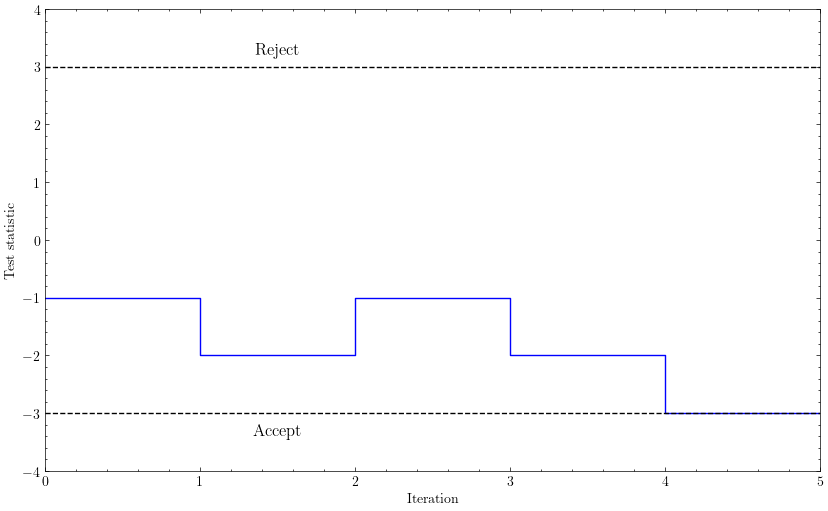

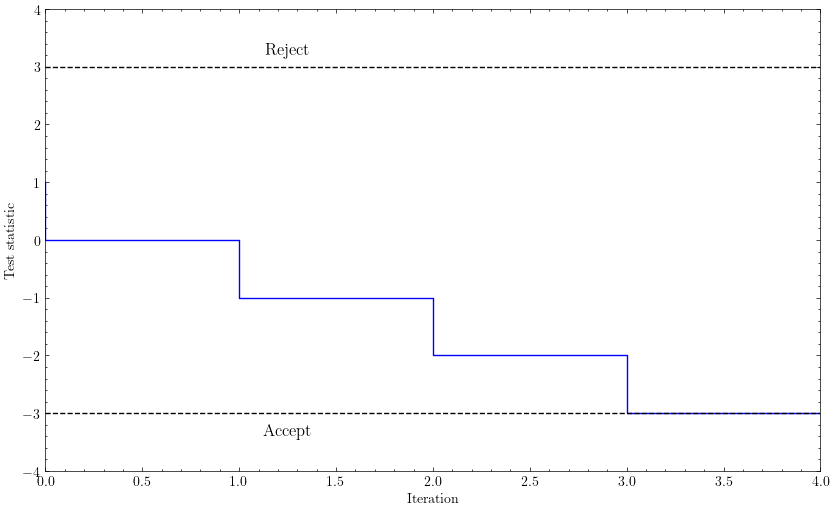

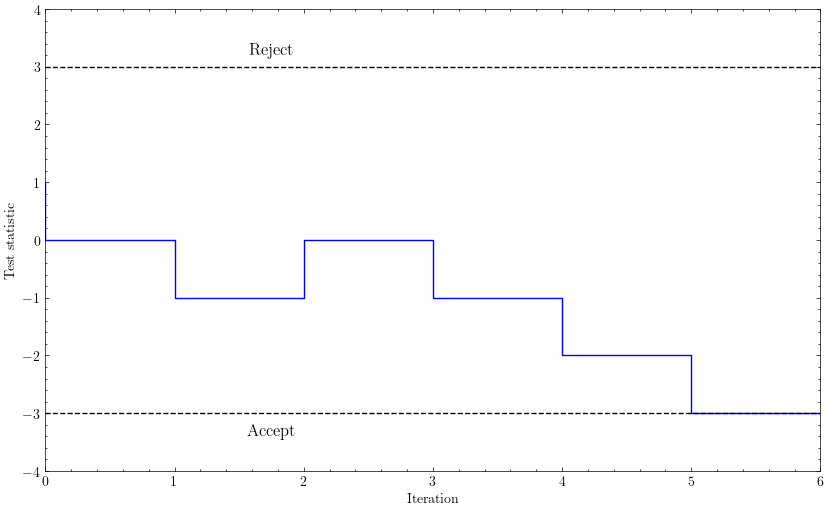

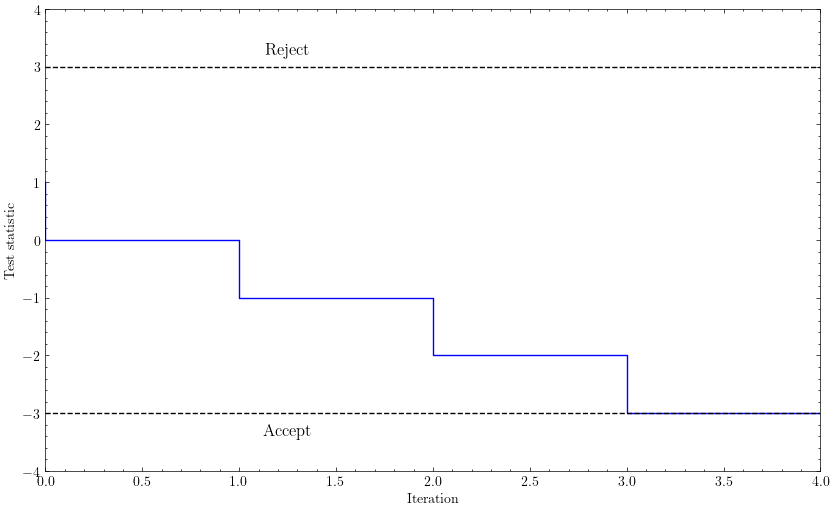

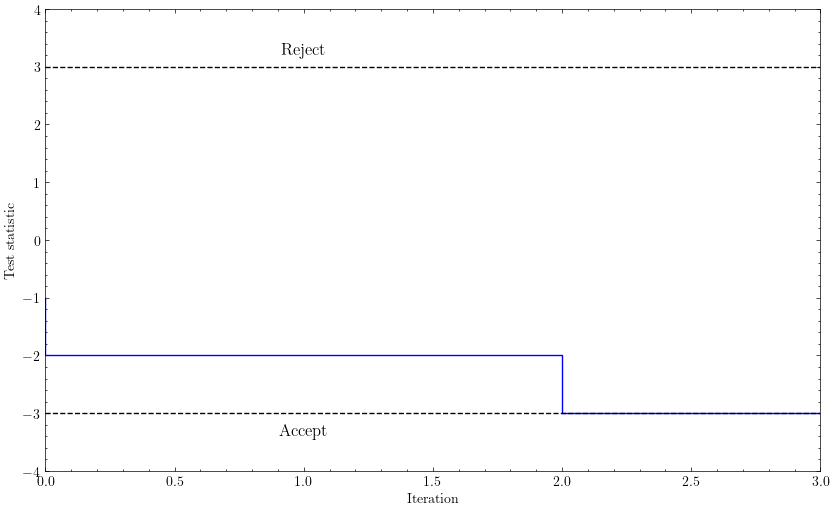

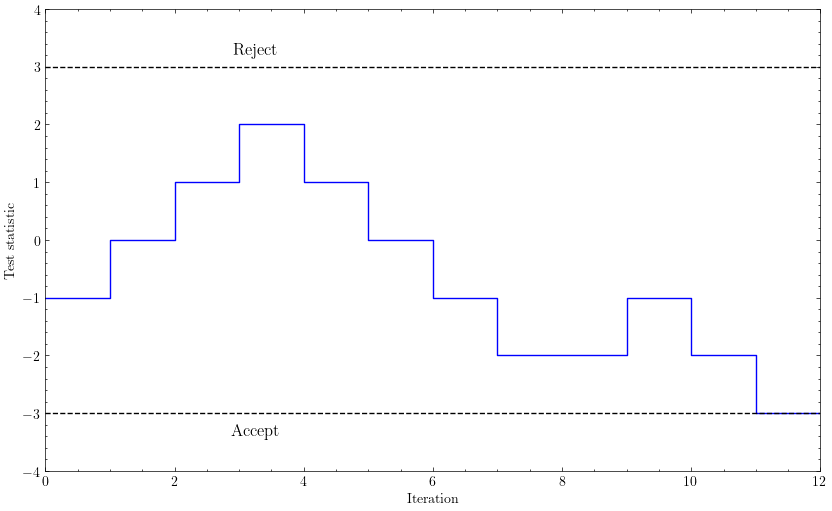

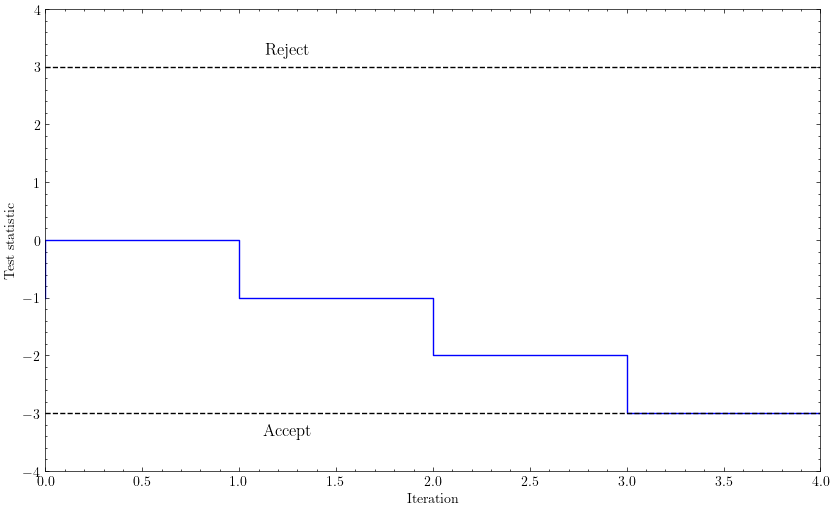

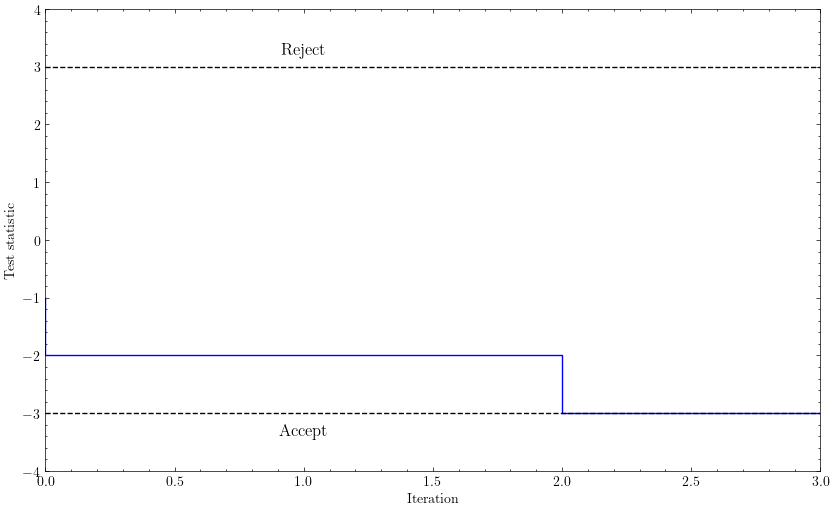

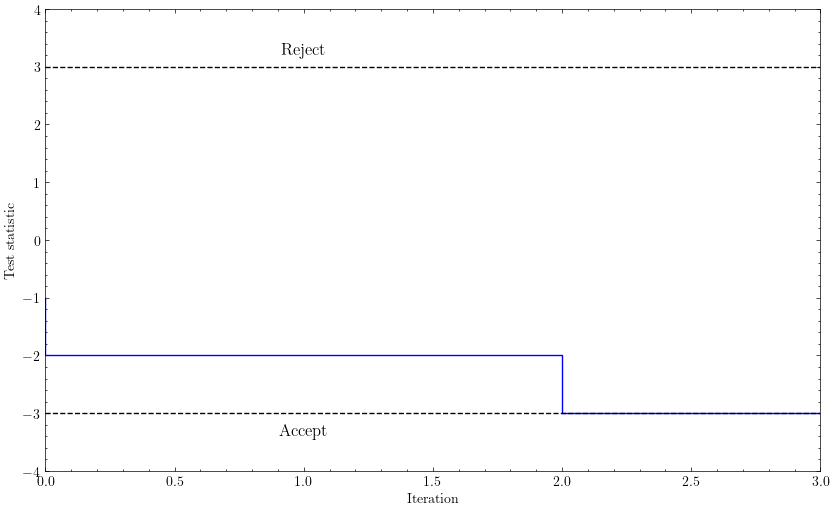

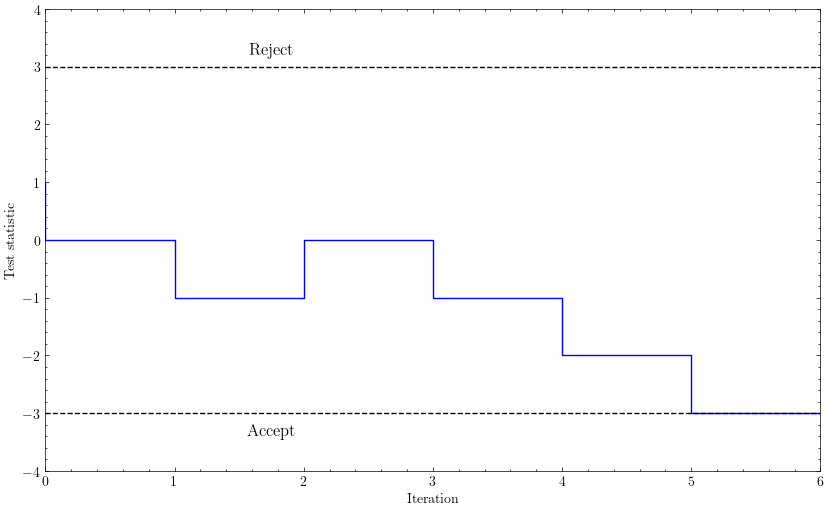

In [183]:
T_total_long = []
for i in T_total:
    if len(i) > 3:
        T_total_long.append(i)
        
draw_random_walk(T_total_long, 3, 10)